In [276]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import logging
import re
import os
import time

# Suppress pandapower logging
logging.getLogger('pandapower').setLevel(logging.ERROR)

import pandapower as pp
import pandapower.networks as nw
import pandapower.shortcircuit as sc
import pandapower.topology as top
import networkx as nx

plt.style.use('seaborn-v0_8-whitegrid')

In [277]:
# Helpfer function to parse MATPOWER .m files
def parse_matpower_case(file_path: str):
    """
    Parse a MATPOWER .m case file and convert to pandapower network.
    
    Parameters
    ----------
    file_path : str
        Path to the .m file
    
    Returns
    -------
    pandapower.Network
        The parsed network
    """
    # Try UTF-8 first, fall back to latin-1 which can read any byte sequence
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='latin-1') as f:
            content = f.read()
    
    # Extract baseMVA
    base_mva_match = re.search(r'mpc\.baseMVA\s*=\s*(\d+\.?\d*)', content)
    base_mva = float(base_mva_match.group(1)) if base_mva_match else 100.0
    
    # Extract bus data
    bus_match = re.search(r'mpc\.bus\s*=\s*\[([^\]]+)\]', content, re.DOTALL)
    bus_data = []
    if bus_match:
        bus_text = bus_match.group(1)
        for line in bus_text.strip().split('\n'):
            line = re.sub(r'%.*', '', line).strip()
            line = line.rstrip(';')
            if line:
                values = [float(x) for x in line.split()]
                if len(values) >= 13:
                    bus_data.append(values)
    
    # Extract branch data
    branch_match = re.search(r'mpc\.branch\s*=\s*\[([^\]]+)\]', content, re.DOTALL)
    branch_data = []
    if branch_match:
        branch_text = branch_match.group(1)
        for line in branch_text.strip().split('\n'):
            line = re.sub(r'%.*', '', line).strip()
            line = line.rstrip(';')
            if line:
                values = [float(x) for x in line.split()]
                if len(values) >= 5:
                    branch_data.append(values)
    
    # Create pandapower network
    net = pp.create_empty_network(name=os.path.basename(file_path).replace('.m', ''))
    
    # Get base voltage from first bus
    base_kv = bus_data[0][9] if len(bus_data[0]) > 9 else 12.66
    
    # Check if loads are in kW (needs conversion) by looking for conversion code or comments
    loads_in_kw = 'convert loads from kW' in content.lower() or 'kw' in content.lower() or 'specified in kW' in content
    
    # Create buses
    for bus in bus_data:
        bus_idx = int(bus[0]) - 1  # Convert to 0-indexed
        pp.create_bus(net, vn_kv=base_kv, name=f"Bus {bus_idx}")
    
    # Add loads (Pd, Qd are columns 2 and 3, 0-indexed)
    for bus in bus_data:
        bus_idx = int(bus[0]) - 1
        p_load = bus[2]  # Pd
        q_load = bus[3]  # Qd
        
        # Convert from kW to MW if file indicates loads are in kW
        if loads_in_kw:
            p_load = p_load / 1000
            q_load = q_load / 1000
        
        if p_load > 0 or q_load > 0:
            pp.create_load(net, bus=bus_idx, p_mw=p_load, q_mvar=q_load)
    
    # Calculate base impedance for conversion
    v_base = base_kv * 1e3  # in Volts
    s_base = base_mva * 1e6  # in VA
    z_base = (v_base ** 2) / s_base
    
    # Check if impedances are in Ohms (needs conversion)
    impedance_in_ohms = 'ohms' in content.lower() or 'Ohms' in content
    
    # Create lines
    for branch in branch_data:
        from_bus = int(branch[0]) - 1  # Convert to 0-indexed
        to_bus = int(branch[1]) - 1
        r = branch[2]
        x = branch[3]
        
        # Convert from Ohms to per-km if in Ohms
        if impedance_in_ohms:
            r_ohm_per_km = r
            x_ohm_per_km = x
        else:
            # Already in p.u., convert to Ohms
            r_ohm_per_km = r * z_base
            x_ohm_per_km = x * z_base
        
        pp.create_line_from_parameters(
            net, from_bus=from_bus, to_bus=to_bus,
            length_km=1, r_ohm_per_km=r_ohm_per_km, x_ohm_per_km=x_ohm_per_km,
            c_nf_per_km=0, max_i_ka=1
        )
    
    # Add external grid at slack bus (bus type 3)
    for bus in bus_data:
        if int(bus[1]) == 3:  # Slack bus
            bus_idx = int(bus[0]) - 1
            pp.create_ext_grid(net, bus=bus_idx, vm_pu=1.0, name="Grid")
            break
    
    return net

In [278]:
class NewtonRaphsonLoadFlow:
    """
    Improved Newton-Raphson Load Flow Implementation
    Based on: Hadi Saadat, 'Power System Analysis', Chapter 6
              Grainger & Stevenson, 'Power System Analysis'
    
    Key improvements for convergence:
    1. Proper Jacobian formulation using polar form
    2. Correct voltage magnitude updates (not dV/V)
    3. Damping factor for stability
    4. Handles transmission systems (generators, transformers)
    5. Proper slack bus detection from ext_grid
    6. PV bus handling for generator buses
    """
    
    def __init__(self, net, tol=1e-4, max_iter=100):
        self.net = copy.deepcopy(net)
        self.tol = tol
        self.max_iter = max_iter
        self.base_mva = 100  # Standard base MVA
        
        # Build bus index mapping (handles non-sequential bus indices)
        self.bus_indices = sorted(net.bus.index.tolist())
        self.n_bus = len(self.bus_indices)
        self.bus_to_int = {bus: i for i, bus in enumerate(self.bus_indices)}
        self.int_to_bus = {i: bus for i, bus in enumerate(self.bus_indices)}
        
    def build_ybus(self):
        """Build admittance matrix from network data including lines and transformers"""
        n = self.n_bus
        Y = np.zeros((n, n), dtype=complex)
        
        # Process lines
        for idx, line in self.net.line.iterrows():
            i = self.bus_to_int[int(line.from_bus)]
            j = self.bus_to_int[int(line.to_bus)]
            
            # Get base impedance for this voltage level
            vn_kv = self.net.bus.at[line.from_bus, 'vn_kv']
            z_base = (vn_kv ** 2) / self.base_mva
            
            r = line.r_ohm_per_km * line.length_km / z_base
            x = line.x_ohm_per_km * line.length_km / z_base
            
            if abs(r) < 1e-10 and abs(x) < 1e-10:
                continue
            
            z = complex(r, x)
            y = 1/z
            
            # Shunt admittance (line charging)
            b_sh = 0
            if hasattr(line, 'c_nf_per_km') and line.c_nf_per_km > 0:
                b_sh = 2 * np.pi * 50 * line.c_nf_per_km * 1e-9 * line.length_km
            
            Y[i, i] += y + 1j * b_sh / 2
            Y[j, j] += y + 1j * b_sh / 2
            Y[i, j] -= y
            Y[j, i] -= y
        
        # Process transformers if present
        if len(self.net.trafo) > 0:
            for idx, trafo in self.net.trafo.iterrows():
                hv_bus = self.bus_to_int[int(trafo.hv_bus)]
                lv_bus = self.bus_to_int[int(trafo.lv_bus)]
                
                # Transformer parameters in per-unit
                sn_mva = trafo.sn_mva
                vn_hv = trafo.vn_hv_kv
                vn_lv = trafo.vn_lv_kv
                
                # Impedance from short-circuit voltage
                vk_percent = trafo.vk_percent
                vkr_percent = trafo.vkr_percent if hasattr(trafo, 'vkr_percent') else 0
                
                z_pu = vk_percent / 100 * (self.base_mva / sn_mva)
                r_pu = vkr_percent / 100 * (self.base_mva / sn_mva)
                x_pu = np.sqrt(max(z_pu**2 - r_pu**2, 0))
                
                z_trafo = complex(r_pu, x_pu)
                if abs(z_trafo) > 1e-10:
                    y_trafo = 1 / z_trafo
                else:
                    y_trafo = complex(1e6, 0)  # Very low impedance
                
                # Tap ratio
                tap_pos = trafo.tap_pos if hasattr(trafo, 'tap_pos') and not pd.isna(trafo.tap_pos) else 0
                tap_step = trafo.tap_step_percent if hasattr(trafo, 'tap_step_percent') and not pd.isna(trafo.tap_step_percent) else 0
                t = 1.0 + (tap_pos * tap_step / 100)
                
                # Add transformer to Y-bus (simplified pi model)
                Y[hv_bus, hv_bus] += y_trafo / (t**2)
                Y[lv_bus, lv_bus] += y_trafo
                Y[hv_bus, lv_bus] -= y_trafo / t
                Y[lv_bus, hv_bus] -= y_trafo / t
        
        return Y
    
    def run(self):
        """Execute Newton-Raphson load flow with improved convergence"""
        # Note: No random seed needed - algorithm is fully deterministic
        # Iterations depend only on: starting point, network data, and tolerance
        
        start_time = time.time()
        n = self.n_bus
        Y = self.build_ybus()
        
        # Initialize voltages - FLAT START (V=1.0 p.u., θ=0°)
        # Using fixed starting point for deterministic iterations
        V = np.ones(n, dtype=np.float64) * 1.0      # All voltages = 1.0 p.u.
        theta = np.zeros(n, dtype=np.float64)        # All angles = 0 radians
        
        # Get scheduled power in per-unit
        P_spec = np.zeros(n, dtype=np.float64)
        Q_spec = np.zeros(n, dtype=np.float64)
        
        # Add loads (negative injection)
        for idx, load in self.net.load.iterrows():
            bus_int = self.bus_to_int[int(load.bus)]
            P_spec[bus_int] -= load.p_mw / self.base_mva
            Q_spec[bus_int] -= load.q_mvar / self.base_mva
        
        # Add generators (positive injection) and identify PV buses
        pv_buses_int = set()
        pv_voltage = {}
        
        for idx, gen in self.net.gen.iterrows():
            bus_int = self.bus_to_int[int(gen.bus)]
            P_spec[bus_int] += gen.p_mw / self.base_mva
            pv_buses_int.add(bus_int)
            # Set voltage setpoint
            vm_pu = gen.vm_pu if hasattr(gen, 'vm_pu') and not pd.isna(gen.vm_pu) else 1.0
            pv_voltage[bus_int] = vm_pu
            V[bus_int] = vm_pu
        
        # Identify slack bus from ext_grid
        slack_buses_int = set()
        for idx, eg in self.net.ext_grid.iterrows():
            bus_int = self.bus_to_int[int(eg.bus)]
            slack_buses_int.add(bus_int)
            vm_pu = eg.vm_pu if hasattr(eg, 'vm_pu') and not pd.isna(eg.vm_pu) else 1.0
            V[bus_int] = vm_pu
        
        # Bus classification
        # Slack: Fixed V and theta
        # PV: Fixed V, variable theta (solve for P)
        # PQ: Variable V and theta (solve for P and Q)
        
        all_buses = set(range(n))
        pq_buses = sorted(list(all_buses - slack_buses_int - pv_buses_int))
        pv_buses = sorted(list(pv_buses_int - slack_buses_int))
        
        n_pq = len(pq_buses)
        n_pv = len(pv_buses)
        non_slack = pq_buses + pv_buses  # Order: PQ then PV
        
        mismatch_history = []
        converged = False
        damping = 1.0
        
        for iteration in range(self.max_iter):
            # Calculate complex voltages
            V_complex = V * np.exp(1j * theta)
            
            # Calculate injected current and power
            I_inj = Y @ V_complex
            S_calc = V_complex * np.conj(I_inj)
            P_calc = S_calc.real
            Q_calc = S_calc.imag
            
            # Power mismatches
            dP_all = P_spec - P_calc
            dQ_all = Q_spec - Q_calc
            
            # For PV buses, only P mismatch matters (Q is free)
            # For PQ buses, both P and Q mismatches matter
            dP = dP_all[non_slack]  # P mismatch for PQ and PV buses
            dQ = dQ_all[pq_buses]   # Q mismatch for PQ buses only
            
            # Check convergence
            if len(dP) > 0 and len(dQ) > 0:
                mismatch = max(np.max(np.abs(dP)), np.max(np.abs(dQ)))
            elif len(dP) > 0:
                mismatch = np.max(np.abs(dP))
            else:
                mismatch = 0
            
            mismatch_history.append(mismatch)
            
            if mismatch < self.tol:
                converged = True
                break
            
            # Build Jacobian matrix
            # For system with PQ and PV buses:
            # [dP]   [J1  J2] [dθ]
            # [dQ] = [J3  J4] [dV/V]  (only for PQ buses)
            
            n_non_slack = len(non_slack)
            
            # J1: dP/dθ for all non-slack buses
            J1 = np.zeros((n_non_slack, n_non_slack))
            # J2: dP/dV for PQ buses only
            J2 = np.zeros((n_non_slack, n_pq))
            # J3: dQ/dθ for PQ buses
            J3 = np.zeros((n_pq, n_non_slack))
            # J4: dQ/dV for PQ buses
            J4 = np.zeros((n_pq, n_pq))
            
            for ii, i in enumerate(non_slack):
                for jj, j in enumerate(non_slack):
                    Gij = Y[i,j].real
                    Bij = Y[i,j].imag
                    theta_ij = theta[i] - theta[j]
                    
                    if i == j:
                        J1[ii, jj] = -Q_calc[i] - Bij * V[i]**2
                    else:
                        J1[ii, jj] = V[i] * V[j] * (Gij * np.sin(theta_ij) - Bij * np.cos(theta_ij))
            
            for ii, i in enumerate(non_slack):
                for jj, j in enumerate(pq_buses):
                    Gij = Y[i,j].real
                    Bij = Y[i,j].imag
                    theta_ij = theta[i] - theta[j]
                    
                    if i == j:
                        J2[ii, jj] = P_calc[i] / V[i] + Gij * V[i]
                    else:
                        J2[ii, jj] = V[i] * (Gij * np.cos(theta_ij) + Bij * np.sin(theta_ij))
            
            for ii, i in enumerate(pq_buses):
                for jj, j in enumerate(non_slack):
                    Gij = Y[i,j].real
                    Bij = Y[i,j].imag
                    theta_ij = theta[i] - theta[j]
                    
                    if i == j:
                        J3[ii, jj] = P_calc[i] - Gij * V[i]**2
                    else:
                        J3[ii, jj] = -V[i] * V[j] * (Gij * np.cos(theta_ij) + Bij * np.sin(theta_ij))
            
            for ii, i in enumerate(pq_buses):
                for jj, j in enumerate(pq_buses):
                    Gij = Y[i,j].real
                    Bij = Y[i,j].imag
                    theta_ij = theta[i] - theta[j]
                    
                    if i == j:
                        J4[ii, jj] = Q_calc[i] / V[i] - Bij * V[i]
                    else:
                        J4[ii, jj] = V[i] * (Gij * np.sin(theta_ij) - Bij * np.cos(theta_ij))
            
            # Assemble Jacobian
            J = np.block([[J1, J2], [J3, J4]])
            
            # Mismatch vector
            mismatch_vec = np.concatenate([dP, dQ])
            
            # Solve for corrections
            try:
                J_reg = J + 1e-10 * np.eye(J.shape[0])
                corrections = np.linalg.solve(J_reg, mismatch_vec)
            except np.linalg.LinAlgError:
                corrections = np.linalg.lstsq(J, mismatch_vec, rcond=None)[0]
            
            # Apply corrections
            d_theta = corrections[:n_non_slack]
            d_V = corrections[n_non_slack:]
            
            for ii, i in enumerate(non_slack):
                theta[i] += damping * d_theta[ii]
            
            for ii, i in enumerate(pq_buses):
                V[i] += damping * d_V[ii]
                V[i] = np.clip(V[i], 0.7, 1.3)
            
            # Reset PV bus voltages to setpoint
            for bus_int, vm in pv_voltage.items():
                V[bus_int] = vm
        
        elapsed_time = time.time() - start_time
        
        return {
            'V': V,
            'delta': np.degrees(theta),
            'iterations': len(mismatch_history),
            'time': elapsed_time,
            'converged': converged,
            'mismatch_history': mismatch_history
        }

print("Newton-Raphson Load Flow class defined (IMPROVED VERSION).")
print("Reference: Hadi Saadat, 'Power System Analysis', 3rd Ed., Chapter 6")
print("Supports: Distribution (PQ) & Transmission (PV/PQ) systems, transformers")

Newton-Raphson Load Flow class defined (IMPROVED VERSION).
Reference: Hadi Saadat, 'Power System Analysis', 3rd Ed., Chapter 6
Supports: Distribution (PQ) & Transmission (PV/PQ) systems, transformers


In [279]:
class FastDecoupledLoadFlow:
    """
    Improved Fast Decoupled Load Flow (FDLF) Implementation
    Based on: Stott & Alsac, IEEE Trans. PAS, 1974
    
    Key improvements:
    1. Uses B' and B'' matrices properly
    2. Handles generators (PV buses) and slack bus detection
    3. Includes transformers in B matrices
    4. Proper bus index mapping for non-sequential indices
    
    Note: FDLF is designed for transmission systems (low R/X ratio).
    For distribution systems with high R/X, use Newton-Raphson instead.
    """
    
    def __init__(self, net, tol=1e-4, max_iter=200):
        self.net = copy.deepcopy(net)
        self.tol = tol
        self.max_iter = max_iter
        self.base_mva = 100
        
        # Build bus index mapping
        self.bus_indices = sorted(net.bus.index.tolist())
        self.n_bus = len(self.bus_indices)
        self.bus_to_int = {bus: i for i, bus in enumerate(self.bus_indices)}
        self.int_to_bus = {i: bus for i, bus in enumerate(self.bus_indices)}
        
    def build_ybus(self):
        """Build admittance matrix including lines and transformers"""
        n = self.n_bus
        Y = np.zeros((n, n), dtype=complex)
        
        # Process lines
        for idx, line in self.net.line.iterrows():
            i = self.bus_to_int[int(line.from_bus)]
            j = self.bus_to_int[int(line.to_bus)]
            
            vn_kv = self.net.bus.at[line.from_bus, 'vn_kv']
            z_base = (vn_kv ** 2) / self.base_mva
            
            r = line.r_ohm_per_km * line.length_km / z_base
            x = line.x_ohm_per_km * line.length_km / z_base
            
            if abs(r) < 1e-10 and abs(x) < 1e-10:
                continue
                
            z = complex(r, x)
            y = 1/z
            
            Y[i, i] += y
            Y[j, j] += y
            Y[i, j] -= y
            Y[j, i] -= y
        
        # Process transformers
        if len(self.net.trafo) > 0:
            for idx, trafo in self.net.trafo.iterrows():
                hv_bus = self.bus_to_int[int(trafo.hv_bus)]
                lv_bus = self.bus_to_int[int(trafo.lv_bus)]
                
                sn_mva = trafo.sn_mva
                vk_percent = trafo.vk_percent
                vkr_percent = trafo.vkr_percent if hasattr(trafo, 'vkr_percent') else 0
                
                z_pu = vk_percent / 100 * (self.base_mva / sn_mva)
                r_pu = vkr_percent / 100 * (self.base_mva / sn_mva)
                x_pu = np.sqrt(max(z_pu**2 - r_pu**2, 0))
                
                z_trafo = complex(r_pu, x_pu)
                if abs(z_trafo) > 1e-10:
                    y_trafo = 1 / z_trafo
                else:
                    y_trafo = complex(1e6, 0)
                
                Y[hv_bus, hv_bus] += y_trafo
                Y[lv_bus, lv_bus] += y_trafo
                Y[hv_bus, lv_bus] -= y_trafo
                Y[lv_bus, hv_bus] -= y_trafo
            
        return Y
    
    def build_b_matrices(self):
        """Build B' and B'' matrices for FDLF including transformers"""
        n = self.n_bus
        Bp = np.zeros((n, n))
        Bpp = np.zeros((n, n))
        
        # Process lines
        for idx, line in self.net.line.iterrows():
            i = self.bus_to_int[int(line.from_bus)]
            j = self.bus_to_int[int(line.to_bus)]
            
            vn_kv = self.net.bus.at[line.from_bus, 'vn_kv']
            z_base = (vn_kv ** 2) / self.base_mva
            
            x = line.x_ohm_per_km * line.length_km / z_base
            
            if abs(x) < 1e-8:
                x = 1e-6
            
            b = -1/x
            
            Bp[i, i] -= b
            Bp[j, j] -= b
            Bp[i, j] += b
            Bp[j, i] += b
            
            Bpp[i, i] -= b
            Bpp[j, j] -= b
            Bpp[i, j] += b
            Bpp[j, i] += b
        
        # Process transformers
        if len(self.net.trafo) > 0:
            for idx, trafo in self.net.trafo.iterrows():
                hv_bus = self.bus_to_int[int(trafo.hv_bus)]
                lv_bus = self.bus_to_int[int(trafo.lv_bus)]
                
                sn_mva = trafo.sn_mva
                vk_percent = trafo.vk_percent
                
                x_pu = vk_percent / 100 * (self.base_mva / sn_mva)
                if abs(x_pu) < 1e-8:
                    x_pu = 1e-6
                
                b = -1/x_pu
                
                Bp[hv_bus, hv_bus] -= b
                Bp[lv_bus, lv_bus] -= b
                Bp[hv_bus, lv_bus] += b
                Bp[lv_bus, hv_bus] += b
                
                Bpp[hv_bus, hv_bus] -= b
                Bpp[lv_bus, lv_bus] -= b
                Bpp[hv_bus, lv_bus] += b
                Bpp[lv_bus, hv_bus] += b
        
        return Bp, Bpp
    
    def run(self):

        
        start_time = time.time()
        n = self.n_bus
        Y = self.build_ybus()
        
        # Initialize voltages - FLAT START (V=1.0 p.u., θ=0°)
        # Using fixed starting point for deterministic iterations
        V = np.ones(n, dtype=np.float64) * 1.0      # All voltages = 1.0 p.u.
        theta = np.zeros(n, dtype=np.float64)        # All angles = 0 radians
        
        # Get scheduled power
        P_spec = np.zeros(n, dtype=np.float64)
        Q_spec = np.zeros(n, dtype=np.float64)
        
        # Add loads
        for idx, load in self.net.load.iterrows():
            bus_int = self.bus_to_int[int(load.bus)]
            P_spec[bus_int] -= load.p_mw / self.base_mva
            Q_spec[bus_int] -= load.q_mvar / self.base_mva
        
        # Add generators and identify PV buses
        pv_buses_int = set()
        pv_voltage = {}
        
        for idx, gen in self.net.gen.iterrows():
            bus_int = self.bus_to_int[int(gen.bus)]
            P_spec[bus_int] += gen.p_mw / self.base_mva
            pv_buses_int.add(bus_int)
            vm_pu = gen.vm_pu if hasattr(gen, 'vm_pu') and not pd.isna(gen.vm_pu) else 1.0
            pv_voltage[bus_int] = vm_pu
            V[bus_int] = vm_pu
        
        # Identify slack buses
        slack_buses_int = set()
        for idx, eg in self.net.ext_grid.iterrows():
            bus_int = self.bus_to_int[int(eg.bus)]
            slack_buses_int.add(bus_int)
            vm_pu = eg.vm_pu if hasattr(eg, 'vm_pu') and not pd.isna(eg.vm_pu) else 1.0
            V[bus_int] = vm_pu
        
        # Bus classification
        all_buses = set(range(n))
        pq_buses = sorted(list(all_buses - slack_buses_int - pv_buses_int))
        pv_buses = sorted(list(pv_buses_int - slack_buses_int))
        non_slack = pq_buses + pv_buses
        
        n_pq = len(pq_buses)
        n_non_slack = len(non_slack)
        
        # Build B matrices
        Bp, Bpp = self.build_b_matrices()
        
        # Extract submatrices
        Bp_sub = Bp[np.ix_(non_slack, non_slack)]
        Bpp_sub = Bpp[np.ix_(pq_buses, pq_buses)]
        
        # Regularization
        Bp_sub += 1e-8 * np.eye(n_non_slack)
        if n_pq > 0:
            Bpp_sub += 1e-8 * np.eye(n_pq)
        
        # Pre-compute inverse
        try:
            Bp_inv = np.linalg.inv(Bp_sub)
            Bpp_inv = np.linalg.inv(Bpp_sub) if n_pq > 0 else np.array([[]])
        except:
            Bp_inv = np.linalg.pinv(Bp_sub)
            Bpp_inv = np.linalg.pinv(Bpp_sub) if n_pq > 0 else np.array([[]])
        
        mismatch_history = []
        converged = False
        accel = 1.0
        
        for iteration in range(self.max_iter):
            V_complex = V * np.exp(1j * theta)
            I_inj = Y @ V_complex
            S_calc = V_complex * np.conj(I_inj)
            P_calc = S_calc.real
            Q_calc = S_calc.imag
            
            # Power mismatches
            dP = P_spec[non_slack] - P_calc[non_slack]
            dQ = Q_spec[pq_buses] - Q_calc[pq_buses] if n_pq > 0 else np.array([])
            
            # Check convergence
            if len(dP) > 0 and len(dQ) > 0:
                mismatch = max(np.max(np.abs(dP)), np.max(np.abs(dQ)))
            elif len(dP) > 0:
                mismatch = np.max(np.abs(dP))
            else:
                mismatch = 0
            
            mismatch_history.append(mismatch)
            
            if mismatch < self.tol:
                converged = True
                break
            
            # P-θ half-iteration
            dP_V = dP / V[non_slack]
            d_theta = Bp_inv @ dP_V
            
            for ii, i in enumerate(non_slack):
                theta[i] += accel * d_theta[ii]
            
            # Q-V half-iteration (only for PQ buses)
            if n_pq > 0:
                dQ_V = dQ / V[pq_buses]
                d_V = Bpp_inv @ dQ_V
                
                for ii, i in enumerate(pq_buses):
                    V[i] += accel * d_V[ii]
                    V[i] = np.clip(V[i], 0.7, 1.3)
            
            # Reset PV bus voltages
            for bus_int, vm in pv_voltage.items():
                V[bus_int] = vm
        
        elapsed_time = time.time() - start_time
        
        return {
            'V': V,
            'delta': np.degrees(theta),
            'iterations': len(mismatch_history),
            'time': elapsed_time,
            'converged': converged,
            'mismatch_history': mismatch_history
        }

print("Fast Decoupled Load Flow class defined (IMPROVED VERSION).")
print("Reference: Stott & Alsac, IEEE Trans. PAS, 1974")
print("Supports: Transmission systems with generators (PV buses) and transformers")

Fast Decoupled Load Flow class defined (IMPROVED VERSION).
Reference: Stott & Alsac, IEEE Trans. PAS, 1974
Supports: Transmission systems with generators (PV buses) and transformers


In [280]:
"""
Power System Analysis Module
============================
A unified module for IEEE 33-bus, 69-bus, and 118-bus distribution/transmission system analysis.

Features:
- Load/Create IEEE test systems
- Load Flow Analysis (Newton-Raphson via pandapower)
- Loss Sensitivity Factor (LSF) calculation for optimal RE placement
- Optimal DG sizing with voltage compliance
- Impact analysis (before/after RE integration)
- Visualization tools

Usage:
    from power_system_analysis import PowerSystemAnalyzer
    
    # Analyze IEEE 33-bus system
    analyzer = PowerSystemAnalyzer(33)
    analyzer.run_full_analysis()
    
    # Or analyze 69-bus or 118-bus
    analyzer = PowerSystemAnalyzer(69)
    analyzer = PowerSystemAnalyzer(118)

Author: KIE4004 Power System Assignment
"""

class PowerSystemAnalyzer:
    """
    Unified Power System Analyzer for IEEE 33, 69, and 118 bus systems.
    
    Parameters
    ----------
    bus_system : int
        The bus system to analyze. Options: 33, 69, or 118
    case_file : str, optional
        Path to MATPOWER .m file for 69-bus system (default: 'case69.m')
    
    Attributes
    ----------
    net : pandapower.Network
        The pandapower network object
    bus_system : int
        The selected bus system
    lsf : dict
        Loss Sensitivity Factors for each bus
    optimal_bus : int
        Optimal bus for DG placement
    optimal_size : float
        Optimal DG size in MW
    results : dict
        Analysis results
    """
    
    def __init__(self, bus_system: int, case_file: str = None):
        """Initialize the analyzer with specified bus system."""
        if bus_system not in [33, 69, 118]:
            raise ValueError("bus_system must be 33, 69, or 118")
        
        self.bus_system = bus_system
        self.case_file = case_file
        self.net = None
        self.lsf = {}
        self.optimal_bus = None
        self.optimal_size = None
        self.base_loss = None
        self.results = {}
        self.net_base = None
        self.net_pv = None
        
        # Load the network
        self._load_network()
        
    def _load_network(self):
        """Load or create the specified IEEE bus system."""
        print(f"\n{'='*70}")
        print(f"Loading IEEE {self.bus_system}-Bus System...")
        print(f"{'='*70}")
        
        if self.bus_system == 33:
            # Use pandapower's built-in case33bw
            self.net = nw.case33bw()
            print("  Source: pandapower.networks.case33bw()")
        elif self.bus_system == 69:
            # Parse from MATPOWER .m file
            if self.case_file is None:
                # Try to find case69.m in current directory or common locations
                possible_paths = [
                    'case69.m',
                    os.path.join(os.getcwd(), 'case69.m')
                ]
                for path in possible_paths:
                    if os.path.exists(path):
                        self.case_file = path
                        break
                
                if self.case_file is None:
                    raise FileNotFoundError(
                        "case69.m file not found. Please provide the path using case_file parameter."
                    )
            
            self.net = parse_matpower_case(self.case_file)
            print(f"  Source: MATPOWER file parser ({self.case_file})")
            print(f"  Reference: Baran & Wu, IEEE Trans. Power Delivery, 1989")
        elif self.bus_system == 118:
            self.net = nw.case118()
            print("  Source: pandapower.networks.case118()")
        
        # Run initial power flow
        pp.runpp(self.net)
        
        self._print_system_info()
    
    def _print_system_info(self):
        """Print system information summary."""
        print(f"\n📊 SYSTEM SPECIFICATIONS:")
        print("-"*50)
        print(f"  Number of Buses:      {len(self.net.bus)}")
        print(f"  Number of Lines:      {len(self.net.line)}")
        if len(self.net.trafo) > 0:
            print(f"  Number of Transformers: {len(self.net.trafo)}")
        print(f"  Number of Loads:      {len(self.net.load)}")
        print(f"  Total Active Load:    {self.net.load.p_mw.sum():.4f} MW")
        print(f"  Total Reactive Load:  {self.net.load.q_mvar.sum():.4f} MVAr")
        
        print(f"\n📈 VOLTAGE PROFILE (Base Case):")
        print("-"*50)
        print(f"  Minimum Voltage:  {self.net.res_bus.vm_pu.min():.4f} p.u. at Bus {self.net.res_bus.vm_pu.idxmin()}")
        print(f"  Maximum Voltage:  {self.net.res_bus.vm_pu.max():.4f} p.u. at Bus {self.net.res_bus.vm_pu.idxmax()}")
        print(f"  Average Voltage:  {self.net.res_bus.vm_pu.mean():.4f} p.u.")


        # Visualise voltage profile (base case)
        fig, ax = plt.subplots(figsize=(12, 5))
        buses = range(len(self.net.bus))
        voltages = self.net.res_bus.vm_pu.values
        
        ax.bar(buses, voltages, color='steelblue', alpha=0.7, edgecolor='navy')
        ax.axhline(y=1.0, color='green', linestyle='--', label='Nominal (1.0 p.u.)')
        ax.axhline(y=0.95, color='red', linestyle='--', label='Lower limit (0.95 p.u.)')
        ax.axhline(y=1.05, color='red', linestyle='--', label='Upper limit (1.05 p.u.)')
        
        ax.set_xlabel('Bus Number', fontsize=12)
        ax.set_ylabel('Voltage (p.u.)', fontsize=12)
        ax.set_title(f'Voltage Profile - IEEE {self.bus_system}-bus (Base Case)', fontsize=14)
        ax.legend(loc='lower right')
        ax.set_ylim([0.9, 1.1])
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

        self.get_power_loss()

    def get_power_loss(self):
        p_loss = self.net.res_line.pl_mw.sum()
        loss_pct = (p_loss / self.net.load.p_mw.sum()) * 100
        print(f"\n⚡ POWER LOSSES (Base Case):")
        print("-"*50)
        print(f"  Active Power Loss:    {p_loss:.4f} MW ({loss_pct:.2f}%)")
        print(f"  Reactive Power Loss:  {self.net.res_line.ql_mvar.sum():.4f} MVAr")
    
    def get_power_balance(self):
        """
        Calculate and display total system power balance for base case.
        
        Returns
        -------
        dict
            Dictionary containing all power balance components
        """
        print(f"\n{'='*70}")
        print(f"⚖️ SYSTEM POWER BALANCE (Base Case) - IEEE {self.bus_system}-Bus")
        print(f"{'='*70}")
        
        # ============ GENERATION ============
        # External grid (slack bus)
        p_ext_grid = self.net.res_ext_grid.p_mw.sum() if len(self.net.res_ext_grid) > 0 else 0
        q_ext_grid = self.net.res_ext_grid.q_mvar.sum() if len(self.net.res_ext_grid) > 0 else 0
        
        # Generators (PV buses)
        p_gen = self.net.res_gen.p_mw.sum() if len(self.net.res_gen) > 0 else 0
        q_gen = self.net.res_gen.q_mvar.sum() if len(self.net.res_gen) > 0 else 0
        
        # Static generators (DG/PV)
        p_sgen = self.net.res_sgen.p_mw.sum() if len(self.net.res_sgen) > 0 else 0
        q_sgen = self.net.res_sgen.q_mvar.sum() if len(self.net.res_sgen) > 0 else 0
        
        # Total generation
        total_p_gen = p_ext_grid + p_gen + p_sgen
        total_q_gen = q_ext_grid + q_gen + q_sgen
        
        # ============ LOAD ============
        total_p_load = self.net.load.p_mw.sum()
        total_q_load = self.net.load.q_mvar.sum()
        
        # ============ LOSSES ============
        # Line losses
        p_loss_line = self.net.res_line.pl_mw.sum()
        q_loss_line = self.net.res_line.ql_mvar.sum()
        
        # Transformer losses
        p_loss_trafo = self.net.res_trafo.pl_mw.sum() if len(self.net.res_trafo) > 0 else 0
        q_loss_trafo = self.net.res_trafo.ql_mvar.sum() if len(self.net.res_trafo) > 0 else 0
        
        # Total losses
        total_p_loss = p_loss_line + p_loss_trafo
        total_q_loss = q_loss_line + q_loss_trafo
        
        # ============ PRINT RESULTS ============
        print(f"\n📥 GENERATION:")
        print(f"   {'Source':<25} {'P (MW)':>12} {'Q (MVAr)':>12}")
        print(f"   {'-'*50}")
        print(f"   {'External Grid (Slack)':<25} {p_ext_grid:>12.4f} {q_ext_grid:>12.4f}")
        if len(self.net.gen) > 0:
            print(f"   {'Generators (PV buses)':<25} {p_gen:>12.4f} {q_gen:>12.4f}")
        if len(self.net.sgen) > 0:
            print(f"   {'Static Generators (DG)':<25} {p_sgen:>12.4f} {q_sgen:>12.4f}")
        print(f"   {'-'*50}")
        print(f"   {'TOTAL GENERATION':<25} {total_p_gen:>12.4f} {total_q_gen:>12.4f}")
        
        print(f"\n📤 LOAD:")
        print(f"   {'Component':<25} {'P (MW)':>12} {'Q (MVAr)':>12}")
        print(f"   {'-'*50}")
        print(f"   {'Total System Load':<25} {total_p_load:>12.4f} {total_q_load:>12.4f}")
        
        print(f"\n🔥 LOSSES:")
        print(f"   {'Component':<25} {'P (MW)':>12} {'Q (MVAr)':>12}")
        print(f"   {'-'*50}")
        print(f"   {'Line Losses':<25} {p_loss_line:>12.4f} {q_loss_line:>12.4f}")
        if len(self.net.trafo) > 0:
            print(f"   {'Transformer Losses':<25} {p_loss_trafo:>12.4f} {q_loss_trafo:>12.4f}")
        print(f"   {'-'*50}")
        print(f"   {'TOTAL LOSSES':<25} {total_p_loss:>12.4f} {total_q_loss:>12.4f}")
        
        # ============ POWER BALANCE VERIFICATION ============
        p_balance = total_p_gen - total_p_load - total_p_loss
        q_balance = total_q_gen - total_q_load - total_q_loss
        
        print(f"\n✅ POWER BALANCE VERIFICATION:")
        print(f"   Generation - Load - Losses = Mismatch")
        print(f"   {'-'*50}")
        print(f"   P: {total_p_gen:.4f} - {total_p_load:.4f} - {total_p_loss:.4f} = {p_balance:.6f} MW")
        print(f"   Q: {total_q_gen:.4f} - {total_q_load:.4f} - {total_q_loss:.4f} = {q_balance:.6f} MVAr")
        
        if abs(p_balance) < 0.01 and abs(q_balance) < 0.1:
            print(f"   ✅ Power balance verified (within tolerance)")
        else:
            print(f"   ⚠️ Power balance mismatch detected")
        
        # ============ SUMMARY STATISTICS ============
        loss_pct = (total_p_loss / total_p_load) * 100
        print(f"\n📊 SUMMARY:")
        print(f"   {'-'*50}")
        print(f"   System Efficiency:     {100 - loss_pct:.2f}%")
        print(f"   Total Loss Percentage: {loss_pct:.2f}%")
        print(f"   Power Factor (Load):   {total_p_load / np.sqrt(total_p_load**2 + total_q_load**2):.4f}")
        print(f"{'='*70}")
        
        return {
            'p_ext_grid': p_ext_grid, 'q_ext_grid': q_ext_grid,
            'p_gen': p_gen, 'q_gen': q_gen,
            'p_sgen': p_sgen, 'q_sgen': q_sgen,
            'total_p_generation': total_p_gen, 'total_q_generation': total_q_gen,
            'total_p_load': total_p_load, 'total_q_load': total_q_load,
            'p_loss_line': p_loss_line, 'q_loss_line': q_loss_line,
            'p_loss_trafo': p_loss_trafo, 'q_loss_trafo': q_loss_trafo,
            'total_p_losses': total_p_loss, 'total_q_losses': total_q_loss,
            'p_balance_mismatch': p_balance, 'q_balance_mismatch': q_balance,
            'loss_percentage': loss_pct,
            'efficiency': 100 - loss_pct
        }
    
    def compare_load_flow_methods(self, tol=1e-4, max_iter_nr=100, max_iter_fdlf=200, plot=True):
        """Compare NR, FDLF, and pandapower results with averaged execution times"""
        print(f"\n{'='*60}")
        print(f"LOAD FLOW ANALYSIS: IEEE {self.bus_system}-bus system")
        print(f"{'='*60}")

        nr = NewtonRaphsonLoadFlow(self.net, tol=tol, max_iter=max_iter_nr)
        nr_result = nr.run()
        
        fdlf = FastDecoupledLoadFlow(self.net, tol=tol, max_iter=max_iter_fdlf)
        fdlf_result = fdlf.run()
        
        # Calculate runtime
        nr_time = nr_result['time']
        fdlf_time = fdlf_result['time']
        
        # Convergence status with symbols
        nr_status = '✅ CONVERGED' if nr_result['converged'] else f"❌ NOT CONVERGED (iter={nr_result['iterations']})"
        fdlf_status = '✅ CONVERGED' if fdlf_result['converged'] else f"⚠️ NOT CONVERGED (iter={fdlf_result['iterations']})"
        
        # Results table - fixed length lists
        results = pd.DataFrame({
            'Method': ['Newton-Raphson', 'Fast Decoupled'],
            'Iterations': [nr_result['iterations'], fdlf_result['iterations']],
            'Runtime (ms)': [f"{nr_time*1000:.2f}", f"{fdlf_time*1000:.2f}"],
            'Converged': [nr_status, fdlf_status]
        })
        
        print("\nComparison Results:")
        print(results.to_string(index=False))
        
        # Show final mismatch for methods that converged
        if nr_result['converged']:
            print(f"\n📊 NR Final Mismatch: {nr_result['mismatch_history'][-1]:.2e}")
        else:
            print(f"\n⚠️ NR Final Mismatch: {nr_result['mismatch_history'][-1]:.2e} (target: 1e-4)")
        
        if fdlf_result['converged']:
            print(f"📊 FDLF Final Mismatch: {fdlf_result['mismatch_history'][-1]:.2e}")
        else:
            print(f"⚠️ FDLF Final Mismatch: {fdlf_result['mismatch_history'][-1]:.2e} (target: 1e-4)")
            print("   Note: FDLF may not converge well for distribution systems (high R/X ratio)")
        
        # Plot convergence comparison
        if plot:
            self._plot_load_flow_convergence(nr_result, fdlf_result, tol)
        
        return nr_result, fdlf_result
    
    def _plot_load_flow_convergence(self, nr_result, fdlf_result, tolerance):
        """Plot maximum power mismatch vs iterations for both methods."""
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Prepare data
        nr_iterations = range(1, len(nr_result['mismatch_history']) + 1)
        fdlf_iterations = range(1, len(fdlf_result['mismatch_history']) + 1)
        
        # Plot convergence curves
        ax.semilogy(nr_iterations, nr_result['mismatch_history'], 
                   'b-o', linewidth=2.5, markersize=8, markerfacecolor='lightblue',
                   markeredgecolor='blue', label='Newton-Raphson (NR)', alpha=0.85)
        
        ax.semilogy(fdlf_iterations, fdlf_result['mismatch_history'], 
                   'r-s', linewidth=2.5, markersize=8, markerfacecolor='lightsalmon',
                   markeredgecolor='red', label='Fast Decoupled (FDLF)', alpha=0.85)
        
        # Add tolerance line
        ax.axhline(y=tolerance, color='green', linestyle='--', linewidth=2, 
                  label=f'Convergence Tolerance ({tolerance:.0e})', alpha=0.7)
        
        # Formatting
        ax.set_xlabel('Iteration Number', fontsize=13, fontweight='bold')
        ax.set_ylabel('Maximum Power Mismatch (p.u.)', fontsize=13, fontweight='bold')
        ax.set_title(f'Load Flow Convergence Comparison - IEEE {self.bus_system}-Bus System', 
                    fontsize=14, fontweight='bold', pad=20)
        
        ax.grid(True, alpha=0.4, linestyle='--', which='both')
        ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
        
        # Add text box with convergence info
        textstr = f'NR: {nr_result["iterations"]} iterations | FDLF: {fdlf_result["iterations"]} iterations'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.5, 0.05, textstr, transform=ax.transAxes, fontsize=11,
               verticalalignment='bottom', horizontalalignment='center', bbox=props)
        
        plt.tight_layout()
        plt.show()
        
        return fig

    def calculate_lsf(self, verbose: bool = True) -> dict:
        """
        Calculate Loss Sensitivity Factor for all candidate buses.
        
        Parameters
        ----------
        verbose : bool
            Whether to print progress information
        
        Returns
        -------
        dict
            Dictionary mapping bus index to LSF value
        """
        if verbose:
            print(f"\n{'='*70}")
            print(f"CALCULATING LOSS SENSITIVITY FACTOR (LSF)")
            print(f"{'='*70}")
        
        net_base = copy.deepcopy(self.net)
        pp.runpp(net_base)
        self.base_loss = net_base.res_line.pl_mw.sum()
        
        # Get excluded buses (generators/ext_grid)
        # gen_buses = set(self.net.gen.bus.tolist()) if len(self.net.gen) > 0 else set()
        # ext_grid_buses = set(self.net.ext_grid.bus.tolist())
        # excluded_buses = gen_buses.union(ext_grid_buses)
        
        # Candidate buses
        candidate_buses = [b for b in range(len(self.net.bus))]# if b not in excluded_buses]
        
        # Delta P for injection test
        delta_p = 0.1 if self.bus_system in [33, 69] else 10.0
        
        self.lsf = {}
        
        if verbose:
            print(f"Analyzing {len(candidate_buses)} candidate buses...")
        
        for i, bus_idx in enumerate(candidate_buses):
            if verbose and i % 20 == 0:
                print(f"  Progress: {i}/{len(candidate_buses)}")
            
            net_test = copy.deepcopy(self.net)
            pp.create_sgen(net_test, bus=bus_idx, p_mw=delta_p, q_mvar=0)
            
            try:
                pp.runpp(net_test)
                new_loss = net_test.res_line.pl_mw.sum()
                self.lsf[bus_idx] = (self.base_loss - new_loss) / delta_p
            except:
                self.lsf[bus_idx] = 0
        
        # Sort and get optimal bus
        sorted_lsf = sorted(self.lsf.items(), key=lambda x: x[1], reverse=True)
        self.optimal_bus = sorted_lsf[0][0]
        
        if verbose:
            print(f"\n{'='*70}")
            print(f"TOP 10 CANDIDATE BUSES FOR SOLAR PV PLACEMENT")
            print(f"{'='*70}")
            print(f"{'Rank':<6}{'Bus':<8}{'LSF':<15}{'Voltage (p.u.)':<18}{'Recommendation'}")
            print("-"*70)
            
            for i, (bus, lsf_val) in enumerate(sorted_lsf[:10], 1):
                voltage = self.net.res_bus.vm_pu.iloc[bus]
                if i <= 3:
                    rec = "⭐⭐⭐ BEST"
                elif i <= 5:
                    rec = "⭐⭐ VERY GOOD"
                else:
                    rec = "⭐ GOOD"
                print(f"{i:<6}{bus:<8}{lsf_val:.6f}       {voltage:.4f}            {rec}")
            
            print(f"\n🎯 OPTIMAL BUS SELECTED: Bus {self.optimal_bus}")
        
        return self.lsf
    
    def optimize_dg_size(self, bus: int = None, max_size_mw: float = None, 
                         steps: int = 30, verbose: bool = True) -> tuple:
        """
        Optimize DG size at specified bus.
        
        Parameters
        ----------
        bus : int
            Bus for DG placement (default: optimal bus from LSF)
        max_size_mw : float
            Maximum DG size to test (default: based on system)
        steps : int
            Number of size steps to test
        verbose : bool
            Whether to print progress information
        
        Returns
        -------
        tuple
            (optimal_size, sizing_results)
        """
        if bus is None:
            if self.optimal_bus is None:
                self.calculate_lsf(verbose=False)
            bus = self.optimal_bus
        
        if max_size_mw is None:
            max_size_mw = {33: 2.5, 69: 3.0, 118: 300.0}[self.bus_system]
        
        min_size = 0.05 if self.bus_system in [33, 69] else 5.0
        sizes = np.linspace(min_size, max_size_mw, steps)
        
        results = {
            'sizes': sizes,
            'losses': [],
            'min_voltage': [],
            'max_voltage': [],
            'voltage_at_bus': [],
            'loss_reduction': []
        }
        
        # Base case
        net_base = copy.deepcopy(self.net)
        pp.runpp(net_base)
        base_loss = net_base.res_line.pl_mw.sum()
        
        if verbose:
            print(f"\n{'='*70}")
            print(f"OPTIMIZING DG SIZE AT BUS {bus}")
            print(f"{'='*70}")
            print(f"Base case loss: {base_loss*1000:.2f} kW")
        
        for size in sizes:
            net_test = copy.deepcopy(self.net)
            pp.create_sgen(net_test, bus=bus, p_mw=size, q_mvar=size*0.33, type='PV')
            
            try:
                pp.runpp(net_test)
                loss = net_test.res_line.pl_mw.sum()
                results['losses'].append(loss)
                results['min_voltage'].append(net_test.res_bus.vm_pu.min())
                results['max_voltage'].append(net_test.res_bus.vm_pu.max())
                results['voltage_at_bus'].append(net_test.res_bus.vm_pu.iloc[bus])
                results['loss_reduction'].append(base_loss - loss)
            except:
                results['losses'].append(np.nan)
                results['min_voltage'].append(np.nan)
                results['max_voltage'].append(np.nan)
                results['voltage_at_bus'].append(np.nan)
                results['loss_reduction'].append(np.nan)
        
        # Find optimal (min loss with voltage compliance)
        valid_indices = []
        for i, (loss, min_v, max_v) in enumerate(zip(results['losses'], 
                                                       results['min_voltage'], 
                                                       results['max_voltage'])):
            if not np.isnan(loss) and min_v >= 0.95 and max_v <= 1.05:
                valid_indices.append(i)
        
        if valid_indices:
            min_loss_idx = min(valid_indices, key=lambda x: results['losses'][x])
        else:
            min_loss_idx = np.nanargmin(results['losses'])
        
        self.optimal_size = sizes[min_loss_idx]
        self.sizing_results = results
        self.sizing_base_loss = base_loss
        
        if verbose:
            print(f"\n📊 OPTIMIZATION RESULTS:")
            print("-"*50)
            print(f"  📍 Location: Bus {bus}")
            print(f"  ☀️  Optimal Size: {self.optimal_size*1000:.0f} kW ({self.optimal_size:.3f} MW)")
            print(f"  Base Loss: {base_loss*1000:.2f} kW")
            print(f"  Optimized Loss: {results['losses'][min_loss_idx]*1000:.2f} kW")
            print(f"  Loss Reduction: {(base_loss - results['losses'][min_loss_idx])*1000:.2f} kW")
            print(f"  % Reduction: {(1 - results['losses'][min_loss_idx]/base_loss)*100:.1f}%")
        
        return self.optimal_size, results
    
    def integrate_pv(self, bus: int = None, size_mw: float = None, pf: float = 0.95):
        """
        Integrate Solar PV at specified bus and run power flow.
        
        Parameters
        ----------
        bus : int
            Bus for PV placement (default: optimal bus)
        size_mw : float
            PV size in MW (default: optimal size)
        pf : float
            Power factor (default: 0.95)
        
        Returns
        -------
        pandapower.Network
            Network with PV integrated
        """
        if bus is None:
            bus = self.optimal_bus
        if size_mw is None:
            size_mw = self.optimal_size
        
        self.net_base = copy.deepcopy(self.net)
        pp.runpp(self.net_base)
        
        self.net_pv = copy.deepcopy(self.net)
        q_mvar = size_mw * np.tan(np.arccos(pf))
        pp.create_sgen(self.net_pv, bus=bus, p_mw=size_mw, q_mvar=q_mvar,
                       name=f"Solar_PV_{size_mw*1000:.0f}kW", type="PV")
        pp.runpp(self.net_pv)
        
        return self.net_pv
    
    def impact_analysis(self, verbose: bool = True) -> pd.DataFrame:
        """
        Perform before/after impact analysis of PV integration.
        
        Parameters
        ----------
        verbose : bool
            Whether to print results
        
        Returns
        -------
        pd.DataFrame
            Comparison dataframe
        """
        if self.net_pv is None:
            self.integrate_pv()
        
        metrics = {
            'Active Power Loss (kW)': [
                self.net_base.res_line.pl_mw.sum()*1000,
                self.net_pv.res_line.pl_mw.sum()*1000
            ],
            'Reactive Power Loss (kVAr)': [
                self.net_base.res_line.ql_mvar.sum()*1000,
                self.net_pv.res_line.ql_mvar.sum()*1000
            ],
            'Minimum Voltage (p.u.)': [
                self.net_base.res_bus.vm_pu.min(),
                self.net_pv.res_bus.vm_pu.min()
            ],
            'Maximum Voltage (p.u.)': [
                self.net_base.res_bus.vm_pu.max(),
                self.net_pv.res_bus.vm_pu.max()
            ],
            'Average Voltage (p.u.)': [
                self.net_base.res_bus.vm_pu.mean(),
                self.net_pv.res_bus.vm_pu.mean()
            ],
            'Buses below 0.95 p.u.': [
                (self.net_base.res_bus.vm_pu < 0.95).sum(),
                (self.net_pv.res_bus.vm_pu < 0.95).sum()
            ]
        }
        
        comparison_df = pd.DataFrame(metrics, index=['Before PV', 'After PV']).T
        comparison_df['Change'] = comparison_df['After PV'] - comparison_df['Before PV']
        
        if verbose:
            print(f"\n{'='*70}")
            print(f"IMPACT ANALYSIS: IEEE {self.bus_system}-BUS SYSTEM")
            print(f"{'='*70}")
            print(f"\n☀️ Solar PV Configuration:")
            print(f"   Location: Bus {self.optimal_bus}")
            print(f"   Size: {self.optimal_size*1000:.0f} kW")
            print(f"\n{'-'*70}")
            print("BEFORE vs AFTER COMPARISON")
            print(f"{'-'*70}")
            print(comparison_df.to_string())
            
            loss_before = metrics['Active Power Loss (kW)'][0]
            loss_after = metrics['Active Power Loss (kW)'][1]
            loss_reduction = loss_before - loss_after
            loss_reduction_pct = (loss_reduction / loss_before) * 100
            
            print(f"\n{'='*70}")
            print("KEY FINDINGS")
            print(f"{'='*70}")
            print(f"✅ Loss Reduction: {loss_reduction:.2f} kW ({loss_reduction_pct:.1f}%)")
            print(f"✅ Min Voltage Improvement: {comparison_df.loc['Minimum Voltage (p.u.)', 'Change']:.4f} p.u.")
            print(f"✅ Voltage Violations Fixed: {int(metrics['Buses below 0.95 p.u.'][0])} → {int(metrics['Buses below 0.95 p.u.'][1])}")
        
        self.comparison_df = comparison_df
        return comparison_df
    
    def plot_voltage_profile(self, figsize: tuple = (16, 10)):
        """Plot voltage profile comparison before and after PV integration."""
        if self.net_pv is None:
            self.integrate_pv()
        
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        
        buses = list(range(len(self.net.bus)))
        v_before = self.net_base.res_bus.vm_pu.values
        v_after = self.net_pv.res_bus.vm_pu.values
        
        # Plot 1: Bar chart comparison (Before vs After)
        ax1 = axes[0]
        width = 0.35
        ax1.bar([b - width/2 for b in buses], v_before, width, label='Before DG', color='coral', alpha=0.7)
        ax1.bar([b + width/2 for b in buses], v_after, width, label='After DG', color='seagreen', alpha=0.7)
        
        ax1.axhline(y=1.0, color='blue', linestyle='--', alpha=0.5, label='Nominal (1.0 p.u.)')
        ax1.axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='Limits (±5%)')
        ax1.axhline(y=1.05, color='red', linestyle='--', alpha=0.5)
        
        # Mark DG location
        ax1.axvline(x=self.optimal_bus, color='green', linestyle='-', linewidth=2, 
                    alpha=0.7, label=f'DG Bus {self.optimal_bus}')
        
        ax1.set_xlabel('Bus Number', fontsize=12)
        ax1.set_ylabel('Voltage (p.u.)', fontsize=12)
        ax1.set_title(f'IEEE {self.bus_system}-Bus: Voltage Profile Before vs After Solar PV Integration', fontsize=14)
        ax1.legend(loc='lower right', fontsize=9)
        ax1.set_ylim([0.9, 1.1])
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Voltage improvement
        ax2 = axes[1]
        v_improvement = (v_after - v_before) * 100
        colors = ['green' if v > 0 else 'red' for v in v_improvement]
        ax2.bar(buses, v_improvement, color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax2.axhline(y=0, color='black', linewidth=1)
        ax2.axvline(x=self.optimal_bus, color='blue', linestyle='--', linewidth=2,
                    label=f'PV Location (Bus {self.optimal_bus})')
        
        ax2.set_xlabel('Bus Number', fontsize=12)
        ax2.set_ylabel('Voltage Change (%)', fontsize=12)
        ax2.set_title('Voltage Improvement After Solar PV Integration', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add annotation for best improvement
        max_improvement_idx = np.argmax(v_improvement)
        ax2.annotate(f'Max: {v_improvement[max_improvement_idx]:.2f}%', 
                    xy=(max_improvement_idx, v_improvement[max_improvement_idx]),
                    xytext=(max_improvement_idx + 3, v_improvement[max_improvement_idx] + 0.5),
                    arrowprops=dict(arrowstyle='->', color='blue'),
                    fontsize=10, color='blue')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def plot_lsf(self, figsize: tuple = (16, 5)):
        """Plot LSF analysis results."""
        if not self.lsf:
            self.calculate_lsf()
        
        # Visualize LSF
        fig, ax = plt.subplots(figsize=(14, 6))

        buses = list(self.lsf.keys())
        values = list(self.lsf.values())

        colors = ['green' if v > np.percentile(values, 70) else 
                'orange' if v > np.percentile(values, 30) else 'gray' for v in values]

        ax.bar(buses, values, color=colors, edgecolor='black', alpha=0.7)
        ax.axhline(y=np.mean(values), color='red', linestyle='--', label=f'Mean LSF: {np.mean(values):.4f}')

        ax.set_xlabel('Bus Number', fontsize=12)
        ax.set_ylabel('Loss Sensitivity Factor', fontsize=12)
        ax.set_title(f'Loss Sensitivity Factor by Bus (IEEE {self.bus_system}-bus)', fontsize=14,pad=20)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Mark best bus
        # Sort by LSF and show top candidates
        sorted_lsf = sorted(self.lsf.items(), key=lambda x: x[1], reverse=True)
        best_bus = sorted_lsf[0][0]
        best_lsf = sorted_lsf[0][1]
        ax.annotate(f'Best: Bus {best_bus}, LSF: {best_lsf:.4f}', xy=(best_bus, best_lsf),
                    xytext=(best_bus+3, best_lsf+0.02),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=10, color='red')

        # Add interpretation box
        # ax.annotate('↑ HIGHER LSF = BETTER location for DG\n(More loss reduction per kW installed)', 
        #             xy=(0.98, 0.85), xycoords='axes fraction',
        #             fontsize=10, verticalalignment='top', horizontalalignment='right',
        #             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

        plt.tight_layout()
        plt.show()
        
        return fig
    
    def plot_sizing_optimization(self, figsize: tuple = (14, 10)):
        """Plot DG sizing optimization results."""
        if not hasattr(self, 'sizing_results'):
            self.optimize_dg_size()
        
        fig, axes = plt.subplots(1, 1, figsize=figsize)
        
        sizes_kw = self.sizing_results['sizes'] * 1000
        base_loss_kw = self.sizing_base_loss * 1000
        losses_kw = [l * 1000 for l in self.sizing_results['losses']]
        loss_reduction_kw = [lr * 1000 for lr in self.sizing_results['loss_reduction']]
        
        # Plot 1: Losses vs Size
        ax1 = axes
        ax1.plot(sizes_kw, losses_kw, 'b-o', linewidth=2, markersize=4)
        ax1.axhline(y=base_loss_kw, color='r', linestyle='--', linewidth=2, label=f'Base: {base_loss_kw:.1f} kW')
        ax1.axvline(x=self.optimal_size*1000, color='g', linestyle='--', linewidth=2, 
                    label=f'Optimal: {self.optimal_size*1000:.0f} kW')
        ax1.set_xlabel('DG Size (kW)', fontsize=11)
        ax1.set_ylabel('System Losses (kW)', fontsize=11)
        ax1.set_title(f'System Losses vs DG Size for IEEE-{self.bus_system}-bus', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
        
        return fig
    
    # ==================== FAULT ANALYSIS METHODS ====================
    
    def _set_sc_parameters(self):
        """
        Set short circuit parameters for the network (IEC 60909 standard).
        
        Sets positive-sequence and zero-sequence parameters for:
        - External grid (source impedance)
        - Lines (zero-sequence impedance)
        """
        net = self.net
        
        # Positive-sequence SC parameters for external grid
        net.ext_grid["s_sc_max_mva"] = 1000
        net.ext_grid["s_sc_min_mva"] = 1000
        net.ext_grid["rx_max"] = 0.1
        net.ext_grid["rx_min"] = 0.1

        # Zero-sequence parameters (IEC 60909 assumption)
        net.ext_grid["x0x_max"] = 3.0
        net.ext_grid["x0x_min"] = 3.0
        net.ext_grid["r0x0_max"] = 0.1
        net.ext_grid["r0x0_min"] = 0.1

        # Line zero-sequence data (typical: 3x positive sequence)
        for line in net.line.index:
            net.line.at[line, "r0_ohm_per_km"] = 3 * net.line.at[line, "r_ohm_per_km"]
            net.line.at[line, "x0_ohm_per_km"] = 3 * net.line.at[line, "x_ohm_per_km"]
            net.line.at[line, "c0_nf_per_km"] = 0

        # Generator short circuit parameters (required for systems with generators)
        if len(net.gen) > 0:
            for gen_idx in net.gen.index:
                gen_bus = net.gen.at[gen_idx, 'bus']
                vn_kv = net.bus.at[gen_bus, 'vn_kv']
                # Set generator SC parameters if not already set
                if 'vn_kv' not in net.gen.columns or pd.isna(net.gen.at[gen_idx, 'vn_kv']):
                    net.gen.at[gen_idx, 'vn_kv'] = vn_kv
                if 'sn_mva' not in net.gen.columns or pd.isna(net.gen.at[gen_idx, 'sn_mva']):
                    # Estimate Sn from Pmax if available, otherwise use typical value
                    p_mw = net.gen.at[gen_idx, 'p_mw'] if 'p_mw' in net.gen.columns else 100
                    net.gen.at[gen_idx, 'sn_mva'] = abs(p_mw) * 1.25 if p_mw != 0 else 100
                if 'rdss_ohm' not in net.gen.columns or pd.isna(net.gen.at[gen_idx, 'rdss_ohm']):
                    net.gen.at[gen_idx, 'rdss_ohm'] = 0
                if 'xdss_pu' not in net.gen.columns or pd.isna(net.gen.at[gen_idx, 'xdss_pu']):
                    net.gen.at[gen_idx, 'xdss_pu'] = 0.2  # Typical subtransient reactance

        # Transformer zero-sequence parameters (if transformers exist)
        if len(net.trafo) > 0:
            for trafo_idx in net.trafo.index:
                if 'vk0_percent' not in net.trafo.columns or pd.isna(net.trafo.at[trafo_idx, 'vk0_percent']):
                    net.trafo.at[trafo_idx, 'vk0_percent'] = net.trafo.at[trafo_idx, 'vk_percent']
                if 'vkr0_percent' not in net.trafo.columns or pd.isna(net.trafo.at[trafo_idx, 'vkr0_percent']):
                    net.trafo.at[trafo_idx, 'vkr0_percent'] = net.trafo.at[trafo_idx, 'vkr_percent']
                if 'mag0_percent' not in net.trafo.columns or pd.isna(net.trafo.at[trafo_idx, 'mag0_percent']):
                    net.trafo.at[trafo_idx, 'mag0_percent'] = 100
                if 'mag0_rx' not in net.trafo.columns or pd.isna(net.trafo.at[trafo_idx, 'mag0_rx']):
                    net.trafo.at[trafo_idx, 'mag0_rx'] = 0
                if 'si0_hv_partial' not in net.trafo.columns or pd.isna(net.trafo.at[trafo_idx, 'si0_hv_partial']):
                    net.trafo.at[trafo_idx, 'si0_hv_partial'] = 0.9
                if 'vector_group' not in net.trafo.columns:
                    net.trafo['vector_group'] = 'Dyn'

        return net
    
    def _get_thevenin_impedance(self, fault_bus_idx):
        """
        Calculate Thevenin impedance from source to fault bus.
        
        Parameters
        ----------
        fault_bus_idx : int
            Index of the fault bus
        
        Returns
        -------
        tuple
            (Z0, Z1, Z2) - Zero, positive, and negative sequence impedances
        """
        net = self.net
        
        # External Grid Impedance
        grid_idx = 0 
        grid_bus_idx = net.ext_grid.at[grid_idx, 'bus']
        
        vn_kv = net.bus.at[grid_bus_idx, 'vn_kv'] 
        s_sc = net.ext_grid.at[grid_idx, 's_sc_max_mva']
        rx_ratio = net.ext_grid.at[grid_idx, 'rx_max']
        c = 1.1  # IEC 60909 Voltage Factor

        z_grid_mag = (c * vn_kv**2) / s_sc
        x_grid = z_grid_mag / np.sqrt(1 + rx_ratio**2)
        r_grid = x_grid * rx_ratio

        Z_grid_1 = complex(r_grid, x_grid)
        ratio = 3.0  # Typical 3 to 5 for solid grounded systems  
        Z_grid_0 = ratio * Z_grid_1

        # Find path from source to fault bus using topology
        graph = top.create_nxgraph(net, respect_switches=False)
        path_buses = nx.shortest_path(graph, grid_bus_idx, fault_bus_idx)
        
        # Sum line impedances along path
        Z_line_sum_1 = 0j
        Z_line_sum_0 = 0j
        
        for i in range(len(path_buses) - 1):
            from_b = path_buses[i]
            to_b = path_buses[i+1]
            
            line = net.line[((net.line.from_bus == from_b) & (net.line.to_bus == to_b)) |
                            ((net.line.from_bus == to_b) & (net.line.to_bus == from_b))]
            
            if len(line) > 0:
                idx = line.index[0]
                length = net.line.at[idx, 'length_km']
                
                Z_line_sum_1 += complex(
                    net.line.at[idx, 'r_ohm_per_km'] * length,
                    net.line.at[idx, 'x_ohm_per_km'] * length
                )
                
                Z_line_sum_0 += complex(
                    net.line.at[idx, 'r0_ohm_per_km'] * length,
                    net.line.at[idx, 'x0_ohm_per_km'] * length
                )

        Z_1_total = Z_grid_1 + Z_line_sum_1
        Z_2_total = Z_1_total  # Negative sequence = Positive sequence
        Z_0_total = Z_grid_0 + Z_line_sum_0
        
        return Z_0_total, Z_1_total, Z_2_total
    
    def _calc_sequence_currents(self, Ea, fault_type, Z0, Z1, Z2, Z_f=0):
        """
        Calculate sequence currents for different fault types.
        
        Parameters
        ----------
        Ea : float
            Pre-fault voltage (phase voltage)
        fault_type : str
            Type of fault: "LG", "LL", or "LLG"
        Z0, Z1, Z2 : complex
            Sequence impedances
        Z_f : float
            Fault impedance (default: 0 for solid fault)
        
        Returns
        -------
        np.array
            Sequence currents [I0, I1, I2]
        """
        if fault_type == "LG":                             
            I = Ea / (Z0 + Z1 + Z2 + 3*Z_f)
            return np.array([I, I, I])

        elif fault_type == "LL":                            
            I1 = Ea / (Z1 + Z2 + Z_f)
            return np.array([0, I1, -I1])

        elif fault_type == "LLG":
            Z_eq = Z0 + 3*Z_f                               
            I1 = Ea / (Z1 + (Z2 * Z_eq) / (Z2 + Z_eq))
            I2 = (Ea - Z1 * I1) / Z2
            I0 = (Ea - I1 * Z1) / Z_eq
            return np.array([I0, I1, I2])
        
        else:
            raise ValueError(f"Invalid fault type: {fault_type}. Use 'LG', 'LL', or 'LLG'")
    
    def _calc_sequence_voltages(self, Ea, Z0, Z1, Z2, I012):
        """Calculate sequence voltages at fault location."""
        V1 = Ea - Z1 * I012[1]
        V2 = -Z2 * I012[2]
        V0 = -Z0 * I012[0]
        return np.array([V0, V1, V2])
    
    def run_fault_analysis(self, fault_bus, fault_type="LG", verbose=True, plot=True):
        """
        Perform comprehensive fault analysis at specified bus.
        
        Parameters
        ----------
        fault_bus : int
            Bus index where fault occurs
        fault_type : str
            Type of fault: "LG" (line-to-ground), "LL" (line-to-line), 
            or "LLG" (line-to-line-to-ground)
        verbose : bool
            Whether to print detailed results
        plot : bool
            Whether to plot the network with fault location
        
        Returns
        -------
        dict
            Fault analysis results
        """
        fault_type = fault_type.upper()
        if fault_type not in ["LG", "LL", "LLG"]:
            raise ValueError(f"Invalid fault type: {fault_type}. Use 'LG', 'LL', or 'LLG'")
        
        # Set SC parameters
        self._set_sc_parameters()
        
        # Base values (IEC 60909)
        c = 1.1  # Voltage factor
        S_base_MVA = 10.0
        S_base = S_base_MVA * 1e6  # VA

        vn_kv = self.net.bus.at[fault_bus, 'vn_kv']
        V_base_LL = vn_kv * 1e3  # Line-line volts
        V_base_phase = V_base_LL / np.sqrt(3)

        Z_base = V_base_LL**2 / S_base
        I_base = S_base / (np.sqrt(3) * V_base_LL)

        Ea = c * V_base_phase  # Pre-fault voltage

        # Run pandapower short circuit
        if fault_type == "LG":
            pp_fault = "1ph"
        else:
            pp_fault = "2ph"
        
        sc.calc_sc(self.net, fault=pp_fault, bus=fault_bus, case="max")

        # Analytical calculation using sequence networks
        Z0, Z1, Z2 = self._get_thevenin_impedance(fault_bus)

        # Transformation matrices
        a = np.exp(1j * 2 * np.pi / 3)
        A = np.array([
            [1, 1, 1],
            [1, a**2, a],
            [1, a, a**2]
        ])

        # Fault currents
        I012 = self._calc_sequence_currents(Ea, fault_type, Z0, Z1, Z2)
        Iabc = A @ I012

        # Fault voltages
        V012 = self._calc_sequence_voltages(Ea, Z0, Z1, Z2, I012)
        Vabc = A @ V012

        # PU conversion
        I012_pu = I012 / I_base
        Iabc_pu = Iabc / I_base
        V012_pu = V012 / V_base_phase
        Vabc_pu = Vabc / V_base_phase

        # Store results
        results = {
            'fault_bus': fault_bus,
            'fault_type': fault_type,
            'Z0': Z0, 'Z1': Z1, 'Z2': Z2,
            'I012': I012, 'Iabc': Iabc,
            'V012': V012, 'Vabc': Vabc,
            'I012_pu': I012_pu, 'Iabc_pu': Iabc_pu,
            'V012_pu': V012_pu, 'Vabc_pu': Vabc_pu,
            'I_base': I_base, 'V_base_phase': V_base_phase,
            'S_base_MVA': S_base_MVA
        }

        if verbose:
            self._print_fault_results(results)
        
        if plot:
            self._plot_fault_network(fault_bus)
        
        return results
    
    def _print_fault_results(self, results):
        """Print formatted fault analysis results."""
        print(f"\n{'='*100}")
        print(f"FAULT ANALYSIS: IEEE {self.bus_system}-BUS SYSTEM")
        print(f"{'='*100}")
        print(f"Fault Type : {results['fault_type']}")
        print(f"Fault Bus  : {results['fault_bus']}")
        print(f"Base S     : {results['S_base_MVA']} MVA")
        
        print(f"\nSEQUENCE IMPEDANCES (Ohm):")
        print(f"   Z0 = {results['Z0']:.4f}")
        print(f"   Z1 = {results['Z1']:.4f}")
        print(f"   Z2 = {results['Z2']:.4f}")
        
        I012 = results['I012']
        Iabc = results['Iabc']
        V012 = results['V012']
        Vabc = results['Vabc']
        
        print(f"\n{'Sequence Currents (A)':<25} | {'Phase Currents (A)':<25} | {'Sequence Voltages (V)':<25} | {'Phase Voltages (V)'}")
        print("-"*100)
        
        labels = [('I0', 'Ia', 'V0', 'Va'), ('I1', 'Ib', 'V1', 'Vb'), ('I2', 'Ic', 'V2', 'Vc')]
        for i, (il, ip, vl, vp) in enumerate(labels):
            print(f"{il} = {I012[i]:>18.4f} | {ip} = {Iabc[i]:>18.4f} | {vl} = {V012[i]:>18.4f} | {vp} = {Vabc[i]:.4f}")
        
        I012_pu = results['I012_pu']
        Iabc_pu = results['Iabc_pu']
        V012_pu = results['V012_pu']
        Vabc_pu = results['Vabc_pu']
        
        print(f"\n{'Sequence Currents (pu)':<25} | {'Phase Currents (pu)':<25} | {'Sequence Voltages (pu)':<25} | {'Phase Voltages (pu)'}")
        print("-"*100)
        
        for i, (il, ip, vl, vp) in enumerate(labels):
            print(f"{il} = {I012_pu[i]:>18.4f} | {ip} = {Iabc_pu[i]:>18.4f} | {vl} = {V012_pu[i]:>18.4f} | {vp} = {Vabc_pu[i]:.4f}")
        
        # Pandapower comparison
        fault_bus = results['fault_bus']
        if fault_bus in self.net.res_bus_sc.index:
            print(f"\n{'='*100}")
            print(f"COMPARISON WITH PANDAPOWER:")
            print("-"*100)
            
            rk_pp = self.net.res_bus_sc.at[fault_bus, "rk_ohm"]
            xk_pp = self.net.res_bus_sc.at[fault_bus, "xk_ohm"]
            Z1_pp = complex(rk_pp, xk_pp)

            print(f"   Thevenin Impedance Z1:")
            print(f"      Analytical: {results['Z1']:.4f} Ohm")
            print(f"      Pandapower: {Z1_pp:.4f} Ohm")
            
            # Zero-sequence impedance only available for unbalanced faults
            if "rk0_ohm" in self.net.res_bus_sc.columns:
                rk0_pp = self.net.res_bus_sc.at[fault_bus, "rk0_ohm"]
                xk0_pp = self.net.res_bus_sc.at[fault_bus, "xk0_ohm"]
                Z0_pp = complex(rk0_pp, xk0_pp)
                
                print(f"\n   Thevenin Impedance Z0:")
                print(f"      Analytical: {results['Z0']:.4f} Ohm")
                print(f"      Pandapower: {Z0_pp:.4f} Ohm")
            else:
                print(f"\n   Thevenin Impedance Z0:")
                print(f"      Analytical: {results['Z0']:.4f} Ohm")
                print(f"      Pandapower: N/A (run 1ph fault for Z0)")

            ikss_pp = self.net.res_bus_sc.at[fault_bus, "ikss_ka"]
            
            # For LL and LLG faults, use Ib for comparison (Ia is zero or not faulted phase)
            fault_type = results['fault_type']
            if fault_type in ["LL", "LLG"]:
                I_analytical_ka = np.abs(results['Iabc'][1]) / 1000  # Use Ib
                phase_label = "Ib"
            else:
                I_analytical_ka = np.abs(results['Iabc'][0]) / 1000  # Use Ia for LG
                phase_label = "Ia"

            print(f"\n   Fault Current |{phase_label}|:")
            print(f"      Analytical: {I_analytical_ka:.4f} kA")
            print(f"      Pandapower: {ikss_pp:.4f} kA")
            print(f"      Difference: {abs(I_analytical_ka - ikss_pp):.4f} kA")
        
        print(f"{'='*100}")
    
    def _plot_fault_network(self, fault_bus):
        """Plot network topology with fault bus highlighted."""
        fig, ax = plt.subplots(figsize=(14, 6))
        
        buses = list(range(len(self.net.bus)))
        y_pos = [0] * len(buses)
        
        colors = ['red' if b == fault_bus else 'steelblue' for b in buses]
        sizes = [200 if b == fault_bus else 50 for b in buses]
        
        ax.scatter(buses, y_pos, c=colors, s=sizes, zorder=3, edgecolors='black')
        
        for idx in self.net.line.index:
            from_bus = self.net.line.at[idx, 'from_bus']
            to_bus = self.net.line.at[idx, 'to_bus']
            ax.plot([from_bus, to_bus], [0, 0], 'k-', alpha=0.3, linewidth=0.5)
        
        ax.annotate(f'FAULT\nBus {fault_bus}', xy=(fault_bus, 0), 
                   xytext=(fault_bus, 0.3),
                   arrowprops=dict(arrowstyle='->', color='red', lw=2),
                   fontsize=12, ha='center', fontweight='bold', color='red')
        
        ax.set_xlim([-2, len(buses) + 2])
        ax.set_ylim([-0.5, 0.8])
        ax.set_xlabel('Bus Number', fontsize=12)
        ax.set_title(f'IEEE {self.bus_system}-Bus Network - Fault at Bus {fault_bus}', 
                    fontsize=14, fontweight='bold')
        ax.set_yticks([])
        ax.grid(True, alpha=0.3, axis='x')
        
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
                   markersize=15, label=f'Fault Bus ({fault_bus})'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', 
                   markersize=10, label='Normal Bus')
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def plot_fault_currents(self, results):
        """Plot phasor diagram of fault currents."""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Sequence currents phasor diagram
        ax1 = axes[0]
        I012 = results['I012']
        labels_012 = ['I0', 'I1', 'I2']
        colors_012 = ['green', 'blue', 'orange']
        
        ax1.axhline(y=0, color='gray', linewidth=0.5)
        ax1.axvline(x=0, color='gray', linewidth=0.5)
        
        for i, (current, label, color) in enumerate(zip(I012, labels_012, colors_012)):
            ax1.arrow(0, 0, np.real(current), np.imag(current), 
                     head_width=max(np.abs(I012))*0.05, head_length=max(np.abs(I012))*0.03,
                     fc=color, ec=color, linewidth=2, 
                     label=f'{label}: {np.abs(current):.2f} A @ {np.angle(current, deg=True):.1f} deg')
        
        max_val = max(np.abs(I012)) * 1.3
        ax1.set_xlim([-max_val, max_val])
        ax1.set_ylim([-max_val, max_val])
        ax1.set_xlabel('Real (A)', fontsize=11)
        ax1.set_ylabel('Imaginary (A)', fontsize=11)
        ax1.set_title(f'Sequence Currents ({results["fault_type"]} Fault)', fontsize=12, fontweight='bold')
        ax1.legend(loc='upper right', fontsize=9)
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # Phase currents phasor diagram
        ax2 = axes[1]
        Iabc = results['Iabc']
        labels_abc = ['Ia', 'Ib', 'Ic']
        colors_abc = ['red', 'gold', 'blue']
        
        ax2.axhline(y=0, color='gray', linewidth=0.5)
        ax2.axvline(x=0, color='gray', linewidth=0.5)
        
        for current, label, color in zip(Iabc, labels_abc, colors_abc):
            ax2.arrow(0, 0, np.real(current), np.imag(current), 
                     head_width=max(np.abs(Iabc))*0.05, head_length=max(np.abs(Iabc))*0.03,
                     fc=color, ec='black', linewidth=2, 
                     label=f'{label}: {np.abs(current):.2f} A @ {np.angle(current, deg=True):.1f} deg')
        
        max_val = max(np.abs(Iabc)) * 1.3
        ax2.set_xlim([-max_val, max_val])
        ax2.set_ylim([-max_val, max_val])
        ax2.set_xlabel('Real (A)', fontsize=11)
        ax2.set_ylabel('Imaginary (A)', fontsize=11)
        ax2.set_title(f'Phase Currents ({results["fault_type"]} Fault at Bus {results["fault_bus"]})', fontsize=12, fontweight='bold')
        ax2.legend(loc='upper right', fontsize=9)
        ax2.grid(True, alpha=0.3)
        ax2.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def compare_fault_types(self, fault_bus, verbose=True):
        """
        Compare all fault types (LG, LL, LLG) at a specified bus.
        
        Parameters
        ----------
        fault_bus : int
            Bus index where fault occurs
        verbose : bool
            Whether to print comparison table
        
        Returns
        -------
        pd.DataFrame
            Comparison of fault currents for different fault types
        """
        fault_types = ["LG", "LL", "LLG"]
        results_list = []
        all_results = []
        
        for ft in fault_types:
            result = self.run_fault_analysis(fault_bus, ft, verbose=False, plot=False)
            all_results.append(result)
            results_list.append({
                'Fault Type': ft,
                '|Ia| (kA)': np.abs(result['Iabc'][0]) / 1000,
                '|Ib| (kA)': np.abs(result['Iabc'][1]) / 1000,
                '|Ic| (kA)': np.abs(result['Iabc'][2]) / 1000,
                '|I1| (kA)': np.abs(result['I012'][1]) / 1000,
                '|I0| (kA)': np.abs(result['I012'][0]) / 1000,
                '|Va| (kV)': np.abs(result['Vabc'][0]) / 1000,
                '|Vb| (kV)': np.abs(result['Vabc'][1]) / 1000,
                '|Vc| (kV)': np.abs(result['Vabc'][2]) / 1000,
                'θa (deg)': np.angle(result['Vabc'][0], deg=True),
                'θb (deg)': np.angle(result['Vabc'][1], deg=True),
                'θc (deg)': np.angle(result['Vabc'][2], deg=True),
            })
        
        comparison_df = pd.DataFrame(results_list)
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"FAULT TYPE COMPARISON AT BUS {fault_bus}")
            print(f"{'='*80}")
            print(comparison_df.to_string(index=False))
            print(f"{'='*80}")
            
            # Create comprehensive plot with 4 subplots
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            x = np.arange(len(fault_types))
            width = 0.25
            
            # Plot 1: Phase Current Magnitudes
            ax1 = axes[0, 0]
            ax1.bar(x - width, comparison_df['|Ia| (kA)'], width, label='|Ia|', color='red', alpha=0.7)
            ax1.bar(x, comparison_df['|Ib| (kA)'], width, label='|Ib|', color='gold', edgecolor='black', alpha=0.7)
            ax1.bar(x + width, comparison_df['|Ic| (kA)'], width, label='|Ic|', color='blue', alpha=0.7)
            ax1.set_xlabel('Fault Type', fontsize=11)
            ax1.set_ylabel('Current Magnitude (kA)', fontsize=11)
            ax1.set_title(f'Phase Current Magnitudes at Bus {fault_bus}', fontsize=12, fontweight='bold')
            ax1.set_xticks(x)
            ax1.set_xticklabels(fault_types)
            ax1.legend()
            ax1.grid(True, alpha=0.3, axis='y')
            
            # Plot 2: Phase Voltage Magnitudes
            ax2 = axes[0, 1]
            ax2.bar(x - width, comparison_df['|Va| (kV)'], width, label='|Va|', color='red', alpha=0.7)
            ax2.bar(x, comparison_df['|Vb| (kV)'], width, label='|Vb|', color='gold', edgecolor='black', alpha=0.7)
            ax2.bar(x + width, comparison_df['|Vc| (kV)'], width, label='|Vc|', color='blue', alpha=0.7)
            ax2.set_xlabel('Fault Type', fontsize=11)
            ax2.set_ylabel('Voltage Magnitude (kV)', fontsize=11)
            ax2.set_title(f'Phase Voltage Magnitudes at Bus {fault_bus}', fontsize=12, fontweight='bold')
            ax2.set_xticks(x)
            ax2.set_xticklabels(fault_types)
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Plot 3: Phase Voltage Angles
            ax3 = axes[1, 0]
            ax3.bar(x - width, comparison_df['θa (deg)'], width, label='θa', color='red', alpha=0.7)
            ax3.bar(x, comparison_df['θb (deg)'], width, label='θb', color='gold', edgecolor='black', alpha=0.7)
            ax3.bar(x + width, comparison_df['θc (deg)'], width, label='θc', color='blue', alpha=0.7)
            ax3.set_xlabel('Fault Type', fontsize=11)
            ax3.set_ylabel('Voltage Phase Angle (degrees)', fontsize=11)
            ax3.set_title(f'Phase Voltage Angles at Bus {fault_bus}', fontsize=12, fontweight='bold')
            ax3.set_xticks(x)
            ax3.set_xticklabels(fault_types)
            ax3.legend()
            ax3.grid(True, alpha=0.3, axis='y')
            ax3.axhline(y=0, color='black', linewidth=0.5)
            
            # Plot 4: Phasor Diagram for all fault types
            ax4 = axes[1, 1]
            colors_ft = {'LG': 'green', 'LL': 'purple', 'LLG': 'orange'}
            
            for i, (ft, result) in enumerate(zip(fault_types, all_results)):
                Iabc = result['Iabc']
                # Normalize for visualization
                I_max = max(np.abs(Iabc))
                if I_max > 0:
                    for j, (current, phase_label) in enumerate(zip(Iabc, ['Ia', 'Ib', 'Ic'])):
                        phase_colors = ['red', 'gold', 'blue']
                        linestyle = ['-', '--', ':'][i]
                        ax4.arrow(0, 0, np.real(current)/I_max, np.imag(current)/I_max,
                                 head_width=0.05, head_length=0.03,
                                 fc=phase_colors[j], ec=phase_colors[j], 
                                 linewidth=1.5, linestyle=linestyle, alpha=0.7)
            
            ax4.set_xlim([-1.5, 1.5])
            ax4.set_ylim([-1.5, 1.5])
            ax4.set_xlabel('Real (normalized)', fontsize=11)
            ax4.set_ylabel('Imaginary (normalized)', fontsize=11)
            ax4.set_title('Current Phasors (normalized)', fontsize=12, fontweight='bold')
            ax4.axhline(y=0, color='gray', linewidth=0.5)
            ax4.axvline(x=0, color='gray', linewidth=0.5)
            ax4.grid(True, alpha=0.3)
            ax4.set_aspect('equal')
            
            # Add legend for phasor plot
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color='red', lw=2, label='Ia'),
                Line2D([0], [0], color='gold', lw=2, label='Ib'),
                Line2D([0], [0], color='blue', lw=2, label='Ic'),
                Line2D([0], [0], color='black', lw=2, linestyle='-', label='LG'),
                Line2D([0], [0], color='black', lw=2, linestyle='--', label='LL'),
                Line2D([0], [0], color='black', lw=2, linestyle=':', label='LLG'),
            ]
            ax4.legend(handles=legend_elements, loc='upper right', fontsize=8)
            
            plt.suptitle(f'IEEE {self.bus_system}-Bus: Fault Analysis Comparison at Bus {fault_bus}', 
                        fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()
        
        return comparison_df
    
    # ==================== END FAULT ANALYSIS METHODS ====================
    
    def run_full_analysis(self, plot: bool = True, compare_methods: bool = True):
        """
        Run complete analysis pipeline.
        
        Parameters
        ----------
        plot : bool
            Whether to generate plots
        compare_methods : bool
            Whether to compare Newton-Raphson and Fast Decoupled methods
        
        Returns
        -------
        dict
            Complete analysis results
        """
        print(f"\n{'#'*70}")
        print(f"# IEEE {self.bus_system}-BUS SYSTEM - FULL ANALYSIS")
        print(f"{'#'*70}")
        self.get_power_balance()
        # Step 1: Load Flow Method Comparison
        if compare_methods:
            self.load_flow_comparison_df = self.compare_load_flow_methods(plot=plot)
        
        # Step 2: LSF calculation
        self.calculate_lsf()
        
        # Step 3: Optimal sizing
        self.optimize_dg_size()
        
        # Step 4: PV integration
        self.integrate_pv()
        
        # Step 5: Impact analysis
        self.impact_analysis()
        
        # Step 6: Plots
        if plot:
            self.plot_lsf()
            self.plot_sizing_optimization()
            self.plot_voltage_profile()
        
        # Step 7: Fault Analysis (use a bus near the middle of the network)
        # Default fault bus: Bus 11 for 33/69-bus, or a mid-range bus for larger systems
        default_fault_bus = min(11, len(self.net.bus) - 1)
        if self.bus_system == 118:
            default_fault_bus = 40  # For 118-bus, bus 40 is valid
        
        # Run all three fault types: LG, LL, LLG with detailed output
        print(f"\n{'#'*70}")
        print(f"# FAULT ANALYSIS - ALL FAULT TYPES AT BUS {default_fault_bus}")
        print(f"{'#'*70}")
        
        # Run each fault type with verbose output to show sequence/phase currents and voltages
        for fault_type in ["LG", "LL", "LLG"]:
            self.run_fault_analysis(default_fault_bus, fault_type=fault_type, verbose=True, plot=False)
        
        # Show comparison table and plot
        self.compare_fault_types(default_fault_bus, verbose=True)
        
        return {
            'bus_system': self.bus_system,
            'optimal_bus': self.optimal_bus,
            'optimal_size_mw': self.optimal_size,
            'lsf': self.lsf,
            'comparison': self.comparison_df,
            'load_flow_comparison': getattr(self, 'load_flow_results', None)
        }


In [281]:
# Convenience functions for quick analysis
def analyze_bus(bus_system: int = 118, plot: bool = True):
    """Quick analysis of specified IEEE bus system."""
    analyzer = PowerSystemAnalyzer(bus_system)
    return analyzer.run_full_analysis(plot=plot)


Loading IEEE 69-Bus System...
  Source: MATPOWER file parser (case69.m)
  Reference: Baran & Wu, IEEE Trans. Power Delivery, 1989

📊 SYSTEM SPECIFICATIONS:
--------------------------------------------------
  Number of Buses:      69
  Number of Lines:      68
  Number of Loads:      48
  Total Active Load:    3.8021 MW
  Total Reactive Load:  2.6947 MVAr

📈 VOLTAGE PROFILE (Base Case):
--------------------------------------------------
  Minimum Voltage:  0.9092 p.u. at Bus 64
  Maximum Voltage:  1.0000 p.u. at Bus 0
  Average Voltage:  0.9734 p.u.


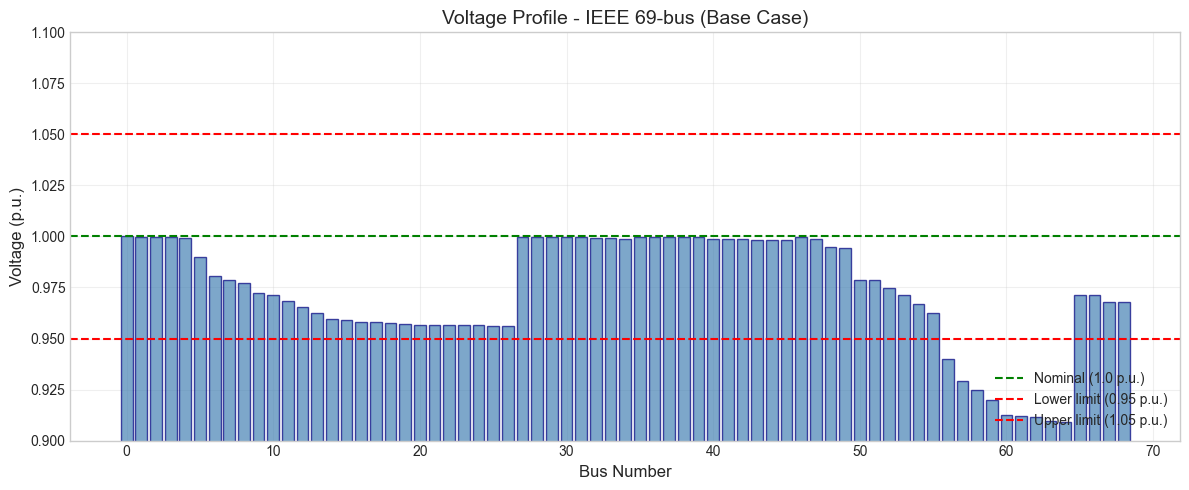


⚡ POWER LOSSES (Base Case):
--------------------------------------------------
  Active Power Loss:    0.2250 MW (5.92%)
  Reactive Power Loss:  0.1022 MVAr

######################################################################
# IEEE 69-BUS SYSTEM - FULL ANALYSIS
######################################################################

⚖️ SYSTEM POWER BALANCE (Base Case) - IEEE 69-Bus

📥 GENERATION:
   Source                          P (MW)     Q (MVAr)
   --------------------------------------------------
   External Grid (Slack)           4.0271       2.7969
   --------------------------------------------------
   TOTAL GENERATION                4.0271       2.7969

📤 LOAD:
   Component                       P (MW)     Q (MVAr)
   --------------------------------------------------
   Total System Load               3.8021       2.6947

🔥 LOSSES:
   Component                       P (MW)     Q (MVAr)
   --------------------------------------------------
   Line Losses                

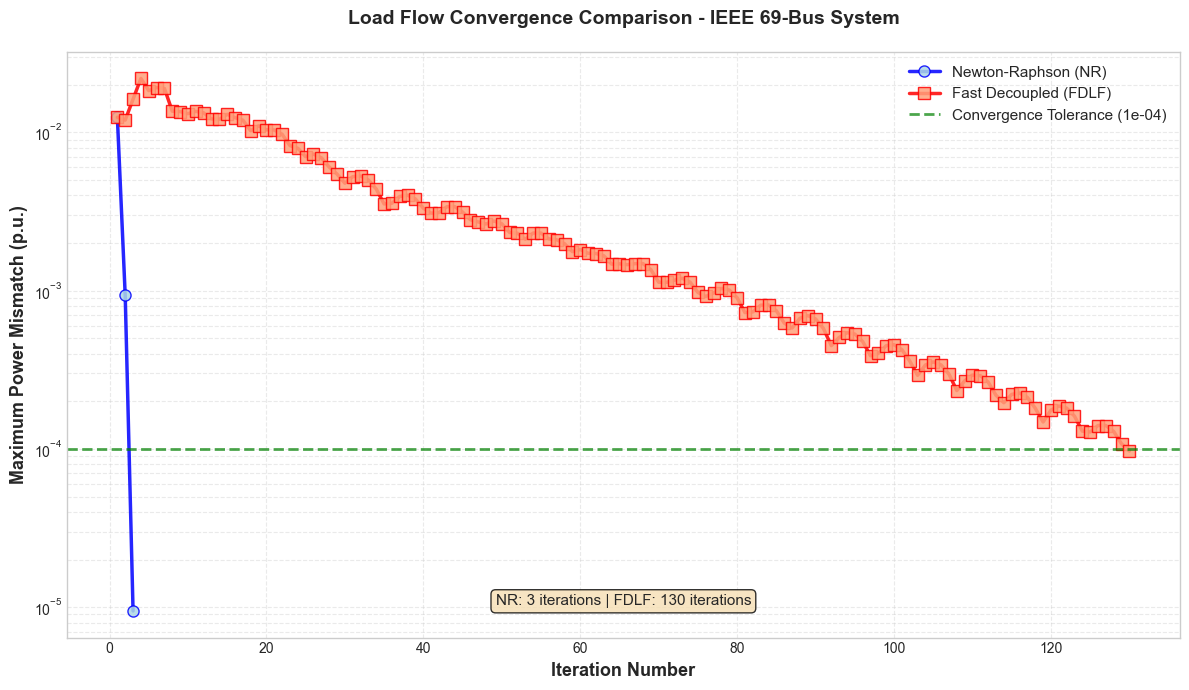


CALCULATING LOSS SENSITIVITY FACTOR (LSF)
Analyzing 69 candidate buses...
  Progress: 0/69
  Progress: 20/69
  Progress: 40/69
  Progress: 60/69

TOP 10 CANDIDATE BUSES FOR SOLAR PV PLACEMENT
Rank  Bus     LSF            Voltage (p.u.)    Recommendation
----------------------------------------------------------------------
1     64      0.162734       0.9092            ⭐⭐⭐ BEST
2     63      0.162563       0.9098            ⭐⭐⭐ BEST
3     62      0.159524       0.9117            ⭐⭐⭐ BEST
4     61      0.158904       0.9120            ⭐⭐ VERY GOOD
5     60      0.158431       0.9123            ⭐⭐ VERY GOOD
6     59      0.144703       0.9197            ⭐ GOOD
7     58      0.134533       0.9248            ⭐ GOOD
8     57      0.126042       0.9290            ⭐ GOOD
9     56      0.104384       0.9401            ⭐ GOOD
10    23      0.068964       0.9566            ⭐ GOOD

🎯 OPTIMAL BUS SELECTED: Bus 64

OPTIMIZING DG SIZE AT BUS 64
Base case loss: 224.99 kW

📊 OPTIMIZATION RESULTS:
---

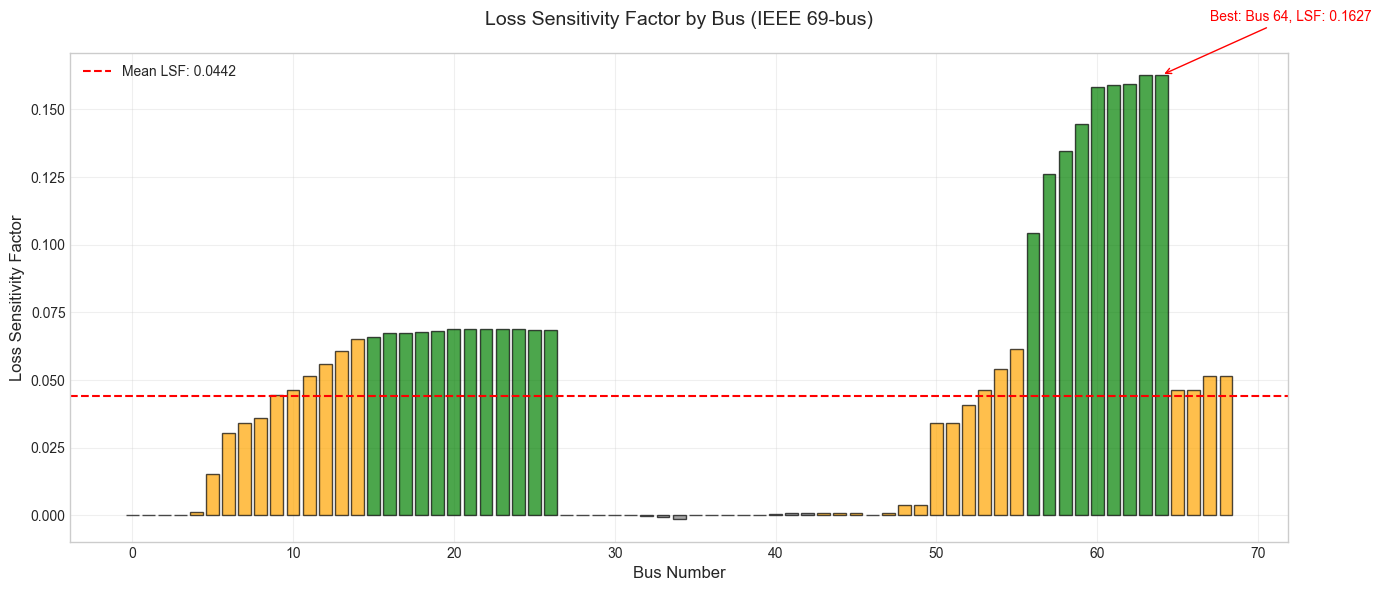

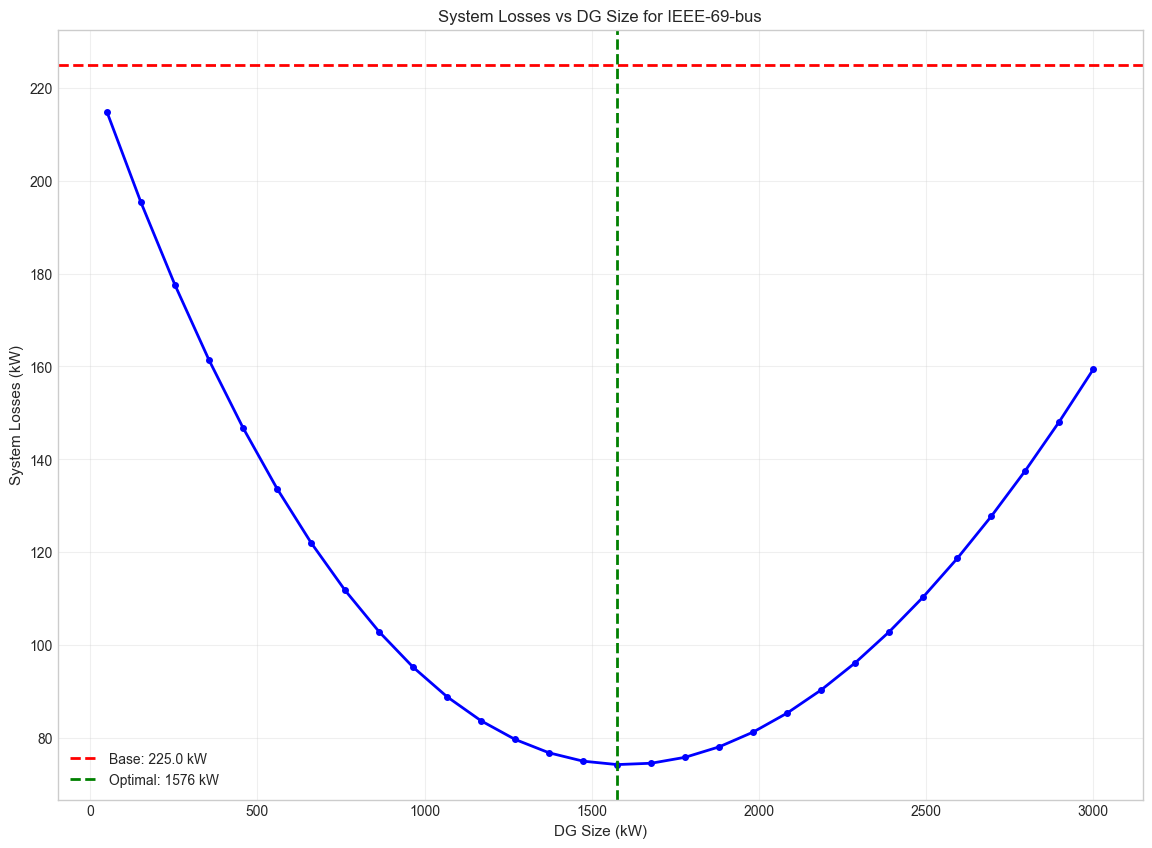

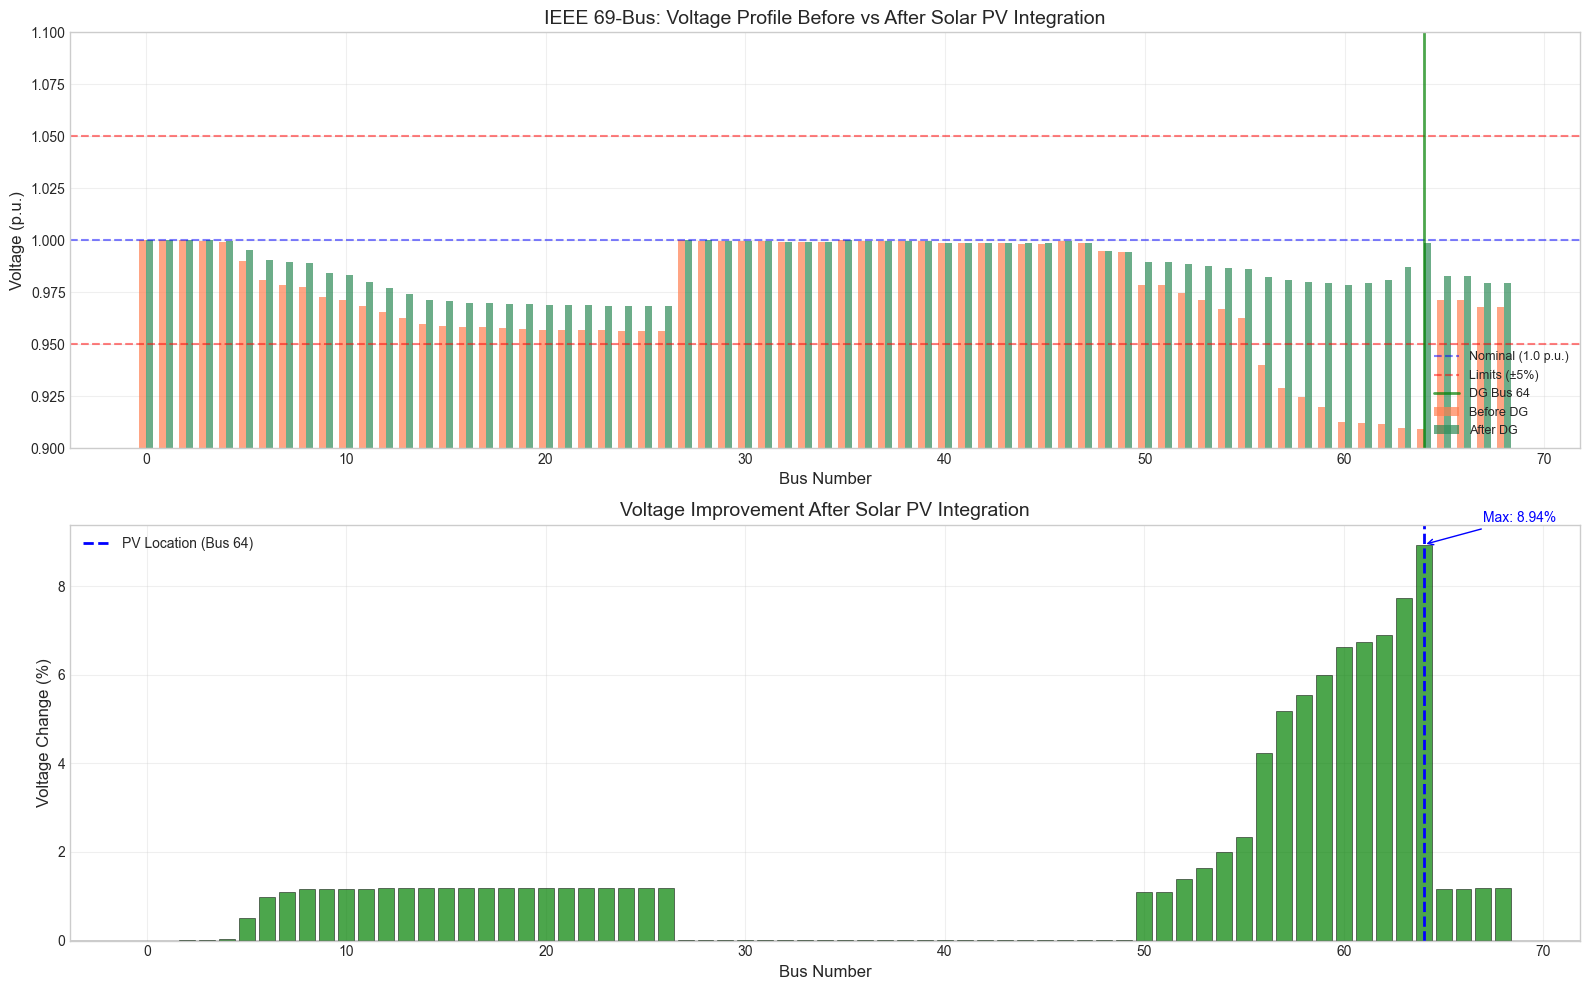


######################################################################
# FAULT ANALYSIS - ALL FAULT TYPES AT BUS 11
######################################################################

FAULT ANALYSIS: IEEE 69-BUS SYSTEM
Fault Type : LG
Fault Bus  : 11
Base S     : 10.0 MVA

SEQUENCE IMPEDANCES (Ohm):
   Z0 = 7.9537+3.6934j
   Z1 = 2.6512+1.2311j
   Z2 = 2.6512+1.2311j

Sequence Currents (A)     | Phase Currents (A)        | Sequence Voltages (V)     | Phase Voltages (V)
----------------------------------------------------------------------------------------------------
I0 = 498.9363-231.6855j | Ia = 1496.8090-695.0566j | V0 = -4824.1079-0.0000j | Va = 0.0000+0.0000j
I1 = 498.9363-231.6855j | Ib =     0.0000+0.0000j | V1 =  6432.1439+0.0000j | Vb = -7236.1619-6963.0000j
I2 = 498.9363-231.6855j | Ic =     0.0000+0.0000j | V2 = -1608.0360+0.0000j | Vc = -7236.1619+6963.0000j

Sequence Currents (pu)    | Phase Currents (pu)       | Sequence Voltages (pu)    | Phase Voltages (pu)
------

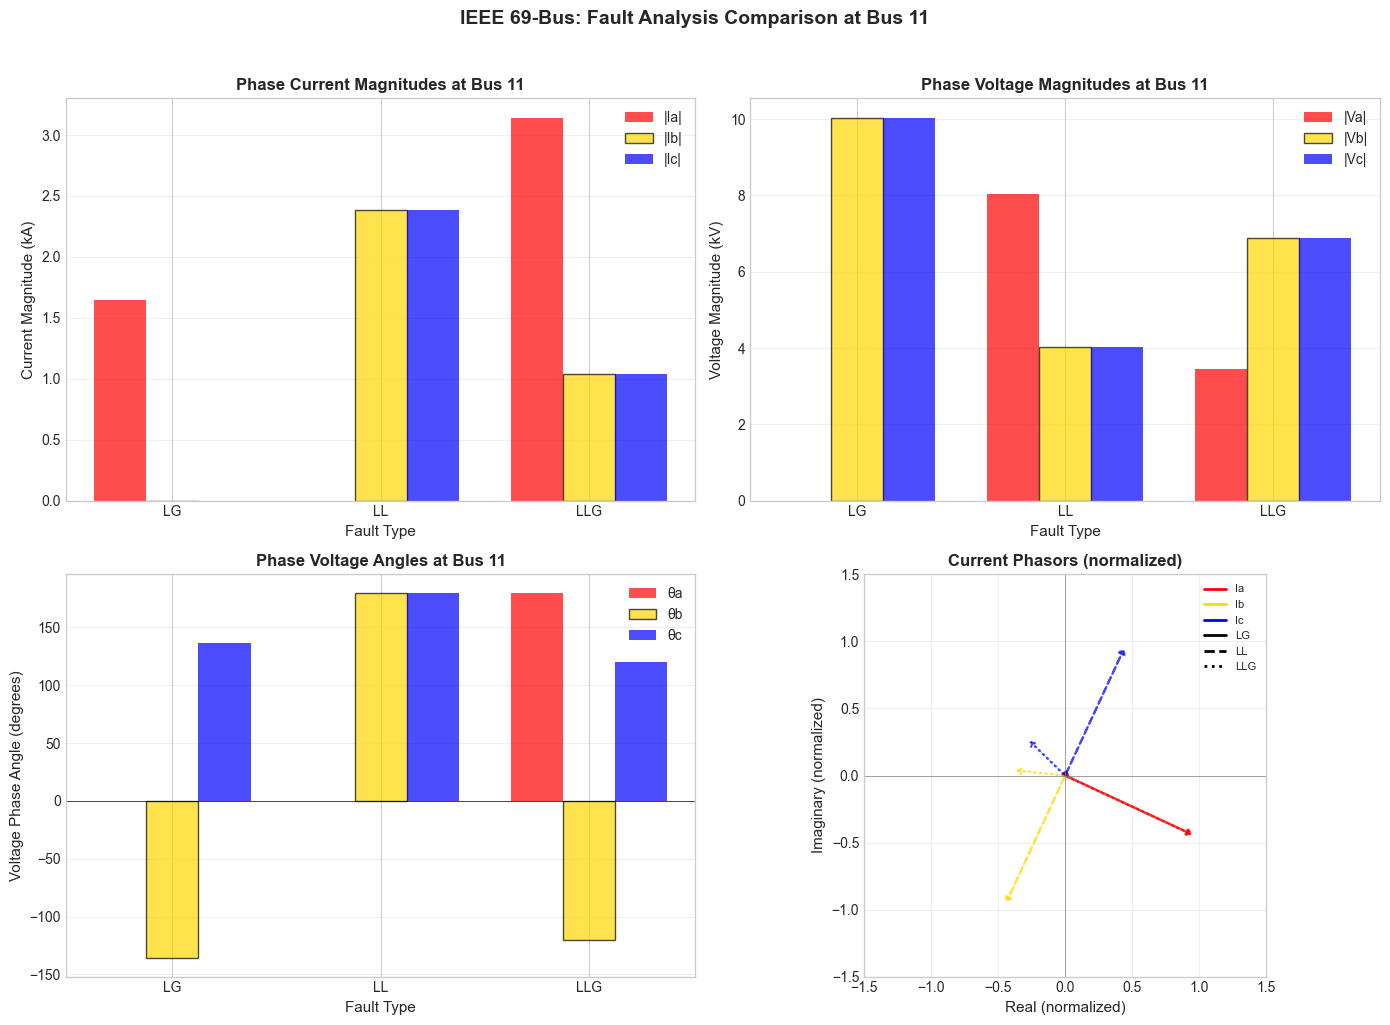

{'bus_system': 69,
 'optimal_bus': 64,
 'optimal_size_mw': np.float64(1.5758620689655174),
 'lsf': {0: np.float64(-5.906386491005833e-12),
  1: np.float64(2.6480341882018088e-05),
  2: np.float64(5.29633257509432e-05),
  3: np.float64(0.00012723254617375002),
  4: np.float64(0.0011035775432668982),
  5: np.float64(0.015453784344003074),
  6: np.float64(0.03061013862009604),
  7: np.float64(0.03426338376123356),
  8: np.float64(0.03614231966518805),
  9: np.float64(0.04445352497809113),
  10: np.float64(0.046286462988629484),
  11: np.float64(0.05146946969920435),
  12: np.float64(0.056069837806540235),
  13: np.float64(0.0606175650354393),
  14: np.float64(0.06510938198384775),
  15: np.float64(0.06594443343422518),
  16: np.float64(0.06728788184169804),
  17: np.float64(0.0673006541490831),
  18: np.float64(0.06790467178720144),
  19: np.float64(0.06829272188041663),
  20: np.float64(0.0689169347660884),
  21: np.float64(0.06891925028692097),
  22: np.float64(0.06893326461265725),
  2

In [282]:
analyze_bus(69)